In [33]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import exists
from hashlib import sha256

from fitting_utils import get_anchors_and_scores_mean_curve, convert_table2, remove_rows_with_nan_or_inf, load_from_parts, remove_bad_fits, failed_fits_statistics,  prepare_total_dataframe, plot_data2, plot_trn_data2, plot_prediction2, plot_prediction_smooth2, get_fun_model_id, get_XY2, get_ranks_from_tables, build_rank_table, convert_to_cd_tables, filter_table, prepare_data_for_cd, make_all_cd_plots, print_pretty_rank_table_transpose, plot_metric, get_relevant_max_anchor, empirical_cdf
from fit_database import fit_model, get_multiple_extrapolations_mean_curve_robust, df_compute_metrics_mean_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing
The data was spread over multiple files. Here, we load the different dataframes and combine them into 1 big dataframe called ``df_total``.

In [2]:
[df_anchors_and_scores, df_metrics, df_extrapolations] = load_from_parts()

In [3]:
df_total = prepare_total_dataframe(df_anchors_and_scores, df_metrics, df_extrapolations)

  0%|          | 0/246 [00:00<?, ?it/s]

In [4]:
df_total

openmlid                           learner  max_anchor_seen  \
0             3                        SVC_linear               45   
1             3                        SVC_linear               64   
2             3                        SVC_linear               91   
3             3                        SVC_linear              128   
4             3                        SVC_linear              181   
...         ...                               ...              ...   
56699     42810  sklearn.tree.ExtraTreeClassifier              512   
56700     42810  sklearn.tree.ExtraTreeClassifier              724   
56701     42810  sklearn.tree.ExtraTreeClassifier             1024   
56702     42810  sklearn.tree.ExtraTreeClassifier             1448   
56703     42810  sklearn.tree.ExtraTreeClassifier             2048   

                                              prediction  \
0      [0.6871956991987469, 0.7358084251013678, 0.779...   
1      [0.6872896613831692, 0.7356441516353385, 0.779...   
2      [0.6873537192715493, 0.7353498699373091, 0.779...   
3      [0.6872911910981312, 0.7354931231290397, 0.779...   
4      [0.6870080420321716, 0.7359803560370154, 0.779...   
...                                                  ...   
56699  [0.560029047279258, 0.570685192188439, 0.57892...   
56700  [0.5617138840082235, 0.5706583863625894, 0.577...   
56701  [0.5614041204696746, 0.5706310423885999, 0.578...   
56702  [0.5625330323470663, 0.570808634126051, 0.5777...   
56703  [0.5629452518922716, 0.5709096877254275, 0.577...   

                                                    beta  fails_init  \
0      [0.9598296244047068, 59.680528820373155, 1.402...           0   
1      [1.0179906696870171, 7.256424514473532, 0.8682...           0   
2      [0.9445764062845252, 1363.9883503403375, 2.047...           0   
3      [0.9560185541622583, 191.79840215690183, 1.641...           0   
4      [0.9755968843816757, 22.420258498280724, 1.173...           0   
...                                                  ...         ...   
56699  [0.6227277698223692, -1.1012620606535517, -0.5...           0   
56700  [0.6393550251902412, -2.4240554174606306, -0.3...           0   
56701  [0.6358449159894225, -2.1605289247399133, -0.4...           0   
56702  [0.6488834961976416, -3.1233514029712626, -0.3...           0   
56703  [0.6545975778122751, -3.503701216078297, -0.28...           0   

       fails_fit       MSE_trn   MSE_tst  MSE_tst_last        L1_trn  \
0              0  5.960944e-07  0.000035  1.143541e-04  5.960944e-07   
1              0  6.533791e-07  0.000904  1.646775e-03  6.533791e-07   
2              0  8.374107e-07  0.000273  6.312668e-04  8.374107e-07   
3              0  8.702641e-07  0.000074  1.964009e-04  8.702641e-07   
4              0  1.250014e-06  0.000031  1.478424e-05  1.250014e-06   
...          ...           ...       ...           ...           ...   
56699          0  3.316475e-05  0.000105  8.197082e-05  3.316475e-05   
56700          0  3.465686e-05  0.000019  2.176908e-07  3.465686e-05   
56701          0  3.215084e-05  0.000035  3.711369e-06  3.215084e-05   
56702          0  3.225755e-05  0.000008  6.971066e-06  3.225755e-05   
56703          0  3.043014e-05  0.000017  1.679107e-05  3.043014e-05   

         L1_tst   L1_tst_last   n curve_model  \
0      0.000035  1.143541e-04   4        pow4   
1      0.000904  1.646775e-03   5        pow4   
2      0.000273  6.312668e-04   6        pow4   
3      0.000074  1.964009e-04   7        pow4   
4      0.000031  1.478424e-05   8        pow4   
...         ...           ...  ..         ...   
56699  0.000105  8.197082e-05  11   logpower3   
56700  0.000019  2.176908e-07  12   logpower3   
56701  0.000035  3.711369e-06  13   logpower3   
56702  0.000008  6.971066e-06  14   logpower3   
56703  0.000017  1.679107e-05  15   logpower3   

                                       anchor_prediction  \
0      [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 5...   
1     

The meaning of the columns are:
- openmlid: the dataset
- learner: the learner used for the classification task (e.g. SVM, etc.)
- max_anchor_seen: the largest training set point on the averaged learning curve used for fitting the curve model
- anchor_prediction: the x-values on the learning curve (the training set sizes)
- score: the y-values on the learning curve (the accuracy of the learner), note that this is an average over multiple learning curves
- n: number of points on the curve used for fitting the learning curve model
- max_anchor_seen: the largest training set size used in curve fitting
- percentage: the percentage of points used (compared to the total on the curve) used for fitting
- percentage_bucket: a discretized version of the percentage, values are 0.05, 0.10, 0.20, 0.40, 0.80, 1.0.
- curve_model: the curve model that we attempted to fit
- fails_init: how many initial points needed to be tried during the fitting procedure
- fails_fit: how many times the fitting failed
- beta: the parameters of the best fit on the training points on the curve (out of 5 or more fitting attempts)
- MSEs: the MSE on either the training points of the curve (trn), MSE on the testing points on the curve (tst), MSE on the last point on the curve (tst last)
- L1: the same, but then for the L1 (absolute loss)

In case you run into issues with ``load_from_parts()``, I've pickled the dataframe ``df_total`` for you, so you can load it if necessary:

In [5]:
fn_df_total = 'df_total.gz'
if exists(fn_df_total):
    df_total = pd.read_pickle(fn_df_total)
else:
    df_total.to_pickle(fn_df_total, protocol=3)

# Visualize a learning curve and the fit
Here we grab a random learning curve from the database and visualize the fit. Note that the dataframe contains accuracies, but we convert these to error rates in the plot.

visualizing the curve fit of row number 23751


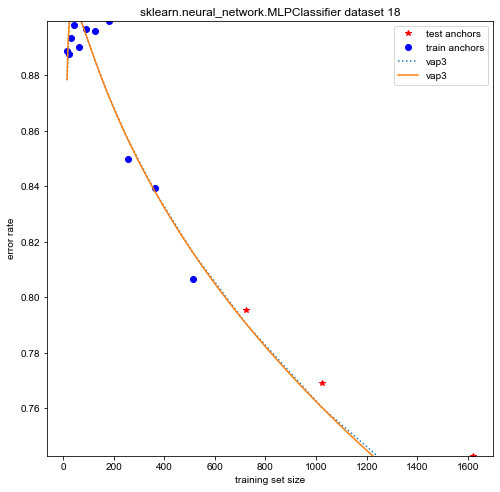

openmlid                                                            18
learner                           sklearn.neural_network.MLPClassifier
max_anchor_seen                                                    512
prediction           [0.1215205189405111, 0.10294822358980985, 0.09...
beta                 [-4.2678503897726765, 16.491332532148267, 0.40...
fails_init                                                           0
fails_fit                                                            0
MSE_trn                                                       0.000134
MSE_tst                                                       0.000338
MSE_tst_last                                                  0.000913
L1_trn                                                        0.000134
L1_tst                                                        0.000338
L1_tst_last                                                   0.000913
n                                                                   11
curve_

In [6]:
num = np.random.randint(0,len(df_total))
row = df_total.iloc[num,:]

print('visualizing the curve fit of row number %d' % num)

plt.figure(figsize=(8,8))

# plots all the points on the curve (red stars)
plot_data2(row)

# plots the points used for training only (blue dots)
plot_trn_data2(row)

# plot the curve fit from the row of the dataframe (dotted)
plot_prediction2(row)

# plot the curve fit using the beta parameters in the dataframe (line)
# this plot is smoother since we can predict any x-value
# this curve should overlap with the curve plotted previously
plot_prediction_smooth2(row)

# show the plot
plt.show()

# show the information of the row
print(row)

Let us retrieve the fitted curve model and make a new prediction:

In [7]:
fitted_curve_model = get_fun_model_id(row.beta, row.curve_model)
x_predict = row.anchor_prediction[-1]*2
y_predict = fitted_curve_model(x_predict)
y_predict

0.3791385880984087

# Repeat the fitting procedure
Let us redo a fit to illustrate the fitting procedure.

In [8]:
# get the X and Y values
# X are training set sizes
# Y are accuracies
[X, Y] = get_XY2(row)

# we need to find the training and test set for the curve data, we do that through the offset
offset = np.argwhere(X == row.max_anchor_seen)[0][0]

# curve training data
X_trn_curve = np.array(X[:offset + 1])
Y_trn_curve = np.array(Y[:offset + 1])

# curve testing data
X_tst_curve = np.array(X[offset + 1:])
Y_tst_curve = np.array(Y[offset + 1:])

experiment_id = '%d-%s-%s-%d' % (row.openmlid,row.learner,row.curve_model,offset)

hash = sha256(experiment_id.encode())
seed = np.frombuffer(hash.digest(), dtype='uint32')
np.random.seed(seed)

# fit the curve model again
[beta_fit_new, fitted_curve_model_new, fails_init, fails_fit] = fit_model(X_trn_curve, Y_trn_curve, X_tst_curve, row.curve_model)

print('best beta found from fitting procedure:')
print(beta_fit_new)
print('the beta provided by the authors:')
print(row.beta)

best beta found from fitting procedure:
[-4.26785163 16.49134011  0.40737041]
the beta provided by the authors:
[-4.26785039 16.49133253  0.40737018]


# Fitting many learning curves
The code in ``fit3_students.py`` takes the file ``lcdb_new.csv`` and fits all learning curve models to all datasets. This procedure takes approximately 20-40 hours to complete. That is why ``fit_students.py`` takes as argument part: part is an integer in [0, 9]. The database is splitted in 10 parts. So if part is 0, the first 10% of the database is processed. This takes about 2-4 hours. I will not do that computation here, because it simply takes extremely long. The results of these computations are stored in ``extrapolations$i.p``, ``anchor_scores$i.p``, ``metrics$i.p``, and these were already loaded above using ``load_from_parts()``. Still, to illustrate how this process went, let us fit all curve models for a single dataset.

Let us first read the learning curve database:

In [9]:
df_performances = pd.read_csv("database-accuracy.csv")
df_performances

openmlid                             learner  size_train  size_test  \
0              44                          SVC_linear          16        461   
1              44                          SVC_linear          23        461   
2              44                          SVC_linear          32        461   
3              44                          SVC_linear          45        461   
4              44                          SVC_linear          64        461   
...           ...                                 ...         ...        ...   
1953366      1464  sklearn.linear_model.SGDClassifier         181         75   
1953367      1464  sklearn.linear_model.SGDClassifier         256         75   
1953368      1464  sklearn.linear_model.SGDClassifier         362         75   
1953369      1464  sklearn.linear_model.SGDClassifier         512         75   
1953370      1464  sklearn.linear_model.SGDClassifier         605         75   

         outer_seed  inner_seed  traintime  score_train  score_valid  \
0                 0           0     0.0024       0.8750       0.7440   
1                 0           0     0.0014       0.9565       0.7222   
2                 0           0     0.0017       0.9375       0.7295   
3                 0           0     0.0023       0.9778       0.8237   
4                 0           0     0.0033       0.7812       0.6280   
...             ...         ...        ...          ...          ...   
1953366           4           4     0.0010       0.8011       0.7647   
1953367           4           4     0.0012       0.7734       0.7647   
1953368           4           4     0.0015       0.7735       0.7647   
1953369           4           4     0.0018       0.4395       0.3676   
1953370           4           4     0.0021       0.7620       0.7647   

         score_test  
0            0.7072  
1            0.6876  
2            0.7180  
3            0.8048  
4            0.6508  
...             ...  
1953366      0.7600  
1953367      0.7600  
1953368      0.7600  
1953369      0.4533  
1953370      0.7600  

[1953371 rows x 10 columns]

The columns are:
- openmlid: the dataset
- learner: the learner trained
- size_train: the maximum number of training sizes used
- size_test: size of the test set
- outer_seed, inner_seed: the seeds that were used to generate the training, validation and test folds (see ECML paper for details)
- score_train: accuracy on train set
- score_valid: accuracy on validation set
- score_test: accuracy on test set

Note that in my experiments, I computed all the learning curves using the validation set, and never used the test sets.

Let us fit all learning curves for a single dataset that is relatively small, to illustrate the process:

In [10]:
df_performances_one_dataset = df_performances.query('openmlid == 1468')
df_performances_one_dataset

openmlid                           learner  size_train  size_test  \
575097      1468                        SVC_linear          16        108   
575098      1468                        SVC_linear          23        108   
575099      1468                        SVC_linear          32        108   
575100      1468                        SVC_linear          45        108   
575101      1468                        SVC_linear          64        108   
...          ...                               ...         ...        ...   
581037      1468  sklearn.tree.ExtraTreeClassifier         181        108   
581038      1468  sklearn.tree.ExtraTreeClassifier         256        108   
581039      1468  sklearn.tree.ExtraTreeClassifier         362        108   
581040      1468  sklearn.tree.ExtraTreeClassifier         512        108   
581041      1468  sklearn.tree.ExtraTreeClassifier         874        108   

        outer_seed  inner_seed  traintime  score_train  score_valid  \
575097           0           0     0.0022          1.0       0.6327   
575098           0           0     0.0015          1.0       0.6429   
575099           0           0     0.0017          1.0       0.6429   
575100           0           0     0.0019          1.0       0.7143   
575101           0           0     0.0020          1.0       0.8571   
...            ...         ...        ...          ...          ...   
581037           4           4     0.0011          1.0       0.6735   
581038           4           4     0.0014          1.0       0.7551   
581039           4           4     0.0020          1.0       0.7143   
581040           4           4     0.0023          1.0       0.8469   
581041           4           4     0.0052          1.0       0.7551   

        score_test  
575097      0.6111  
575098      0.6759  
575099      0.6944  
575100      0.7130  
575101      0.8426  
...            ...  
581037      0.7037  
581038      0.8056  
581039      0.8148  
581040      0.8148  
581041      0.8611  

[5945 rows x 10 columns]

This code below is taken from ``do_job()`` from ``fit3_students.py``.
Note that some computations result in nans, because some of the fits are so bad, that they cause overflows or divisions by zero.
Fitting the curves, computing the metrics, and computing the X, Y values (anchors and scores mean curve) takes about 2 minutes for this dataset.

In [11]:
np.seterr(all='print')

print('computing extrapolations...')
# compute the fits
df_extrapolations = get_multiple_extrapolations_mean_curve_robust(df_performances_one_dataset)
df_extrapolations.to_pickle('extrapolations_example.gz', protocol=3)

print('computing anchors and scores...')
# compute the X, Y values and store them for later use
df_anchors_and_scores = get_anchors_and_scores_mean_curve(df_performances_one_dataset)
df_anchors_and_scores.to_pickle('anchors_scores_example.gz', protocol=3)

print('computing metrics....')
# compute the metrics and other information (L2 losses, etc.)
df_metrics = df_compute_metrics_mean_curve(df_extrapolations, df_anchors_and_scores)
df_metrics.to_pickle('metrics_example.gz', protocol=3)

computing extrapolations...


  3%|▎         | 9/320 [00:01<00:44,  7.01it/s]

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4


  4%|▍         | 12/320 [00:04<02:01,  2.54it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3


  4%|▍         | 13/320 [00:05<02:04,  2.46it/s]

fit failed, nan error? True inf error? False model? expp3


  9%|▉         | 28/320 [00:12<02:14,  2.17it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3


  9%|▉         | 29/320 [00:13<02:13,  2.18it/s]

initial value failed, retrying for  expp3


 14%|█▍        | 44/320 [00:19<02:05,  2.20it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 19%|█▉        | 60/320 [00:25<01:52,  2.31it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3


 19%|█▉        | 61/320 [00:26<01:52,  2.31it/s]

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 24%|██▍       | 76/320 [00:30<01:39,  2.46it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 25%|██▌       | 80/320 [00:31<01:34,  2.54it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 27%|██▋       | 86/320 [00:33<01:31,  2.56it/s]

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4


 29%|██▉       | 92/320 [00:36<01:31,  2.49it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3


 29%|██▉       | 93/320 [00:37<01:30,  2.50it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 33%|███▎      | 105/320 [00:38<01:19,  2.71it/s]

fit failed, nan error? True inf error? False model? mmf4


 34%|███▍      | 108/320 [00:42<01:22,  2.56it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3


 38%|███▊      | 121/320 [00:44<01:13,  2.71it/s]

fit failed, nan error? True inf error? False model? mmf4


 39%|███▉      | 124/320 [00:47<01:14,  2.62it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 39%|███▉      | 125/320 [00:47<01:14,  2.61it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3


 42%|████▏     | 135/320 [00:49<01:07,  2.74it/s]

fit failed, nan error? True inf error? False model? mmf4


 44%|████▍     | 140/320 [00:51<01:06,  2.70it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 44%|████▍     | 141/320 [00:52<01:06,  2.69it/s]

fit failed, nan error? True inf error? False model? expp3


 49%|████▉     | 156/320 [00:56<00:59,  2.76it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3


 49%|████▉     | 157/320 [00:57<00:59,  2.75it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3


 53%|█████▎    | 169/320 [00:58<00:52,  2.89it/s]

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4


 54%|█████▍    | 172/320 [01:01<00:53,  2.78it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 58%|█████▊    | 185/320 [01:03<00:46,  2.91it/s]

fit failed, nan error? True inf error? False model? mmf4


 59%|█████▉    | 188/320 [01:05<00:46,  2.87it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 63%|██████▎   | 201/320 [01:07<00:39,  2.98it/s]

fit failed, nan error? True inf error? False model? mmf4


 64%|██████▍   | 204/320 [01:10<00:40,  2.88it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3


 64%|██████▍   | 205/320 [01:11<00:40,  2.87it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 68%|██████▊   | 218/320 [01:13<00:34,  2.98it/s]

fit failed, nan error? True inf error? False model? mmf4


 69%|██████▉   | 220/320 [01:14<00:33,  2.95it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 70%|███████   | 224/320 [01:15<00:32,  2.98it/s]

initial value failed, retrying for  expp3


 74%|███████▍  | 236/320 [01:22<00:29,  2.86it/s]

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 74%|███████▍  | 237/320 [01:23<00:29,  2.85it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 78%|███████▊  | 250/320 [01:26<00:24,  2.90it/s]

fit failed, nan error? True inf error? False model? mmf4


 79%|███████▉  | 252/320 [01:27<00:23,  2.89it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3


 80%|████████  | 256/320 [01:27<00:21,  2.91it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 84%|████████▍ | 268/320 [01:30<00:17,  2.95it/s]

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3


 84%|████████▍ | 269/320 [01:31<00:17,  2.94it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3


 87%|████████▋ | 278/320 [01:32<00:14,  2.99it/s]

fit failed, nan error? True inf error? False model? mmf4


 89%|████████▉ | 284/320 [01:36<00:12,  2.95it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 90%|█████████ | 288/320 [01:36<00:10,  2.97it/s]

fit failed, nan error? True inf error? False model? expp3


 94%|█████████▍| 300/320 [01:41<00:06,  2.95it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3


 94%|█████████▍| 301/320 [01:42<00:06,  2.95it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3


 99%|█████████▉| 316/320 [01:46<00:01,  2.96it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


 99%|█████████▉| 317/320 [01:47<00:01,  2.95it/s]

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3


100%|██████████| 320/320 [01:47<00:00,  2.97it/s]

computing anchors and scores...


  0%|          | 0/1 [00:00<?, ?it/s]

computing metrics....


100%|██████████| 2544/2544 [00:03<00:00, 640.59it/s]


Now you have seen how the fitting procedure was done on all the learning curves. Let us now go back to the complete database and do some analysis.

# Cleaning
As you have seen, many of the learning curve fits didn't succeed. That is why we removed some fits that we deemed 'bad'. The criteria for removal are:
- the fitting had to be restarted more than 100 times to get a decent solution (e.g. we gave up trying to perform fitting to avoid infinite loop), we denote this reason as ``fail``.
- we had to try more than 1000 initial points for the fitting to get started at all (also to avoid infinite loops). note that this never happened in any of the experiments. we denote this reason also as ``fail`` if it would ever occur.
- after the fitting has converged, the best solution obtained Nan or Inf values when extrapolating or interpolating the learning curve, we denote this reason as  ``nan_or_inf``
- the MSE on the train, test or test last point was larger than 100 (some performances are so large that they may cause buffer overflows?) we denote this reason as ``too_bad``


In [12]:
[df_clean, df_removed] = remove_bad_fits(df_total)

fail due to init 0
fail due to fit 450
fail total 450
number of rows with nans / infs: 459
columns with nans / infs:
openmlid           False
learner            False
max_anchor_seen    False
fails_init         False
fails_fit          False
MSE_trn            False
MSE_tst             True
MSE_tst_last        True
dtype: bool
performance too bad for analysis:
MSE_trn            97
MSE_tst         23900
MSE_tst_last    31124
dtype: int64
number of offending rows:
31134


Lets have a look what was removed and why:

In [13]:
df_failed_statistics = failed_fits_statistics(df_removed)
df_failed_statistics

curve_model  fail  nan_or_inf  too_bad  total
0         exp2   446         422    17307  18175
1         exp3     0          15      554    569
2         exp4     0           6      395    401
3        expd3     0          10      626    636
4        expp3     4           0      270    274
5         lin2     0           0     7672   7672
6    logpower3     0           0       16     16
7         mmf4     0           0      267    267
8         pow2     0           0       61     61
9         pow3     0           0      714    714
10        pow4     0           0     2294   2294
11        vap3     0           0      210    210
12        wbl4     0           6      748    754
13         all   450         459    31134  32043

Let us compute the overall percentages of the failed fits compared to all fitting experiments performed:

In [14]:
df_failed_statistics.iloc[-1,1:5]/len(df_total)

fail          0.000514
nan_or_inf    0.000524
too_bad       0.035537
total         0.036574
Name: 13, dtype: object

So in total 3.6% of all fitting experiments have been discarded.

# Group results together
For the analysis it is sometimes useful to group all results together, we do that here. Note that this computation takes quite some time: 25 min per performance metric. So I've pickled the results for you.

In [15]:
fn_MSE_tst_last = 'table_MSE_tst_last.gz'
fn_MSE_tst = 'table_MSE_tst.gz'
fn_MSE_trn = 'table_MSE_trn.gz'

if exists(fn_MSE_tst_last):
    table_MSE_tst_last = pd.read_pickle(fn_MSE_tst_last)
else:
    table_MSE_tst_last = convert_table2(df_clean,'MSE_tst_last')
    table_MSE_tst_last.to_pickle(fn_MSE_tst_last, protocol=3)

if exists(fn_MSE_tst):
    table_MSE_tst = pd.read_pickle(fn_MSE_tst)
else:
    table_MSE_tst = convert_table2(df_clean,'MSE_tst')
    table_MSE_tst.to_pickle(fn_MSE_tst, protocol=3)

if exists(fn_MSE_trn):
    table_MSE_trn = pd.read_pickle(fn_MSE_trn)
else:
    table_MSE_trn = convert_table2(df_clean,'MSE_trn')
    table_MSE_trn.to_pickle(fn_MSE_trn, protocol=3)


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/246 [00:00<?, ?it/s]

Let us look at the resulting tables. For example, let us look at ``table_MSE_tst_last``. This table lists all MSE's for extrapolating to the last point for all experiments (including nans). See below how the new dataframe looks like:

In [16]:
table_MSE_tst_last

openmlid                           learner   n  bucket  percentage  \
0             3                        SVC_linear   4    0.05    0.017388   
1             3                        SVC_linear   5    0.05    0.024730   
2             3                        SVC_linear   6    0.05    0.035162   
3             3                        SVC_linear   7    0.05    0.049459   
4             3                        SVC_linear   8    0.10    0.069938   
...         ...                               ...  ..     ...         ...   
54752     42810  sklearn.tree.ExtraTreeClassifier  11    0.20    0.158025   
54753     42810  sklearn.tree.ExtraTreeClassifier  12    0.40    0.223457   
54754     42810  sklearn.tree.ExtraTreeClassifier  13    0.40    0.316049   
54755     42810  sklearn.tree.ExtraTreeClassifier  14    0.80    0.446914   
54756     42810  sklearn.tree.ExtraTreeClassifier  15    0.80    0.632099   

           pow4          pow3      pow2      log2      exp2  ...       lin2  \
0      0.000114  5.977532e-02  0.940059  0.145012       NaN  ...        NaN   
1      0.001647  4.352816e-02  0.940059  0.131277       NaN  ...  77.067071   
2      0.000631  1.377450e-02  0.258181  0.106000       NaN  ...  40.902939   
3      0.000196  6.695784e-03  0.179143  0.083691       NaN  ...  21.322832   
4      0.000015  4.197498e-03  0.124327  0.065183       NaN  ...  10.731518   
...         ...           ...       ...       ...       ...  ...        ...   
54752  0.000008  7.679005e-05  0.000404  0.000330  0.092859  ...   0.057757   
54753  0.000039  5.962681e-08  0.000400  0.000334  0.047848  ...   0.033417   
54754  0.000024  2.912928e-06  0.000249  0.000212  0.016409  ...   0.013110   
54755  0.000043  7.734689e-06  0.000230  0.000200  0.007560  ...   0.006498   
54756  0.000047  1.756560e-05  0.394806  0.000163  0.002744  ...   0.002538   

          last1          vap3          mmf4          wbl4          exp4  \
0      0.022014  1.734396e-01  6.685887e-03  1.287311e-02  1.287311e-02   
1      0.011607  1.275765e-01  9.926919e-04  1.348527e-04  1.348546e-04   
2      0.006362  5.485902e-02  2.218349e-04  2.101238e-03  2.101237e-03   
3      0.003172  2.922272e-02  4.723047e-05  9.327093e-04  9.327098e-04   
4      0.001317  1.788741e-02  2.380743e-05  1.757911e-04  1.757912e-04   
...         ...           ...           ...           ...           ...   
54752  0.000235  1.061759e-07  5.995664e-05  8.044675e-05  7.685010e-05   
54753  0.000015  4.097655e-05  1.108744e-07  7.841662e-08  6.086402e-08   
54754  0.000073  1.463987e-05  2.915524e-06  2.915682e-06  2.930489e-06   
54755  0.000004  4.384037e-05  7.735771e-06  7.642298e-06  7.708745e-06   
54756  0.000008  4.752749e-05  1.756838e-05  1.757031e-05  1.755315e-05   

          expp3         ilog2     expd3     logpower3  
0      0.023644  1.090247e-03  0.008044  2.273271e-02  
1      0.021200  2.476565e-03  0.004781  1.825708e-02  
2      0.017205  3.157290e-03  0.003897  4.680238e-03  
3      0.024120  3.494093e-03  0.002705  2.177777e-03  
4      0.023049  3.630293e-03  0.001662  1.476714e-03  
...         ...           ...       ...           ...  
54752  0.000006  2.094676e-05  0.000320  8.197082e-05  
54753  0.000034  6.188161e-06  0.000155  2.176908e-07  
54754  0.000021  6.450426e-06  0.000123  3.711369e-06  
54755  0.000040  8.786978e-07  0.000051  6.971066e-06  
54756  0.000043  2.681432e-09  0.000019  1.679107e-05  

[54757 rows x 21 columns]

The nans occur because some of the curve models did not find a good fit (and were removed during cleaning), but because of the grouping they popped up again. We can remove rows with any nans as follows.

In [17]:
table_MSE_tst_last_no_nan_or_inf = remove_rows_with_nan_or_inf(table_MSE_tst_last)
table_MSE_tst_last_no_nan_or_inf

openmlid                           learner   n  bucket  percentage  \
6             3                        SVC_linear  10     0.2    0.139876   
7             3                        SVC_linear  11     0.2    0.197836   
8             3                        SVC_linear  12     0.4    0.279753   
9             3                        SVC_linear  13     0.4    0.395672   
10            3                        SVC_linear  14     0.8    0.559505   
...         ...                               ...  ..     ...         ...   
54752     42810  sklearn.tree.ExtraTreeClassifier  11     0.2    0.158025   
54753     42810  sklearn.tree.ExtraTreeClassifier  12     0.4    0.223457   
54754     42810  sklearn.tree.ExtraTreeClassifier  13     0.4    0.316049   
54755     42810  sklearn.tree.ExtraTreeClassifier  14     0.8    0.446914   
54756     42810  sklearn.tree.ExtraTreeClassifier  15     0.8    0.632099   

           pow4          pow3      pow2      log2       exp2  ...      lin2  \
6      0.000041  8.952671e-04  0.052078  0.033588  14.619379  ...  2.201971   
7      0.000036  4.480632e-04  0.033006  0.023188   2.987556  ...  0.933794   
8      0.000033  2.192130e-04  0.020475  0.015530   0.748582  ...  0.373325   
9      0.000033  1.005744e-04  0.012340  0.010041   0.203254  ...  0.137514   
10     0.000022  5.301634e-05  0.007322  0.006357   0.055302  ...  0.045880   
...         ...           ...       ...       ...        ...  ...       ...   
54752  0.000008  7.679005e-05  0.000404  0.000330   0.092859  ...  0.057757   
54753  0.000039  5.962681e-08  0.000400  0.000334   0.047848  ...  0.033417   
54754  0.000024  2.912928e-06  0.000249  0.000212   0.016409  ...  0.013110   
54755  0.000043  7.734689e-06  0.000230  0.000200   0.007560  ...  0.006498   
54756  0.000047  1.756560e-05  0.394806  0.000163   0.002744  ...  0.002538   

          last1          vap3          mmf4          wbl4          exp4  \
6      0.000385  3.913114e-03  1.407285e-05  2.118821e-04  2.118820e-04   
7      0.000185  1.865160e-03  1.635661e-05  2.510512e-06  1.467115e-04   
8      0.000104  8.480871e-04  1.874461e-05  1.075274e-04  1.075274e-04   
9      0.000068  3.526794e-04  2.169929e-05  8.463267e-05  8.463265e-05   
10     0.000018  1.592694e-04  1.585810e-05  8.692794e-06  5.400160e-05   
...         ...           ...           ...           ...           ...   
54752  0.000235  1.061759e-07  5.995664e-05  8.044675e-05  7.685010e-05   
54753  0.000015  4.097655e-05  1.108744e-07  7.841662e-08  6.086402e-08   
54754  0.000073  1.463987e-05  2.915524e-06  2.915682e-06  2.930489e-06   
54755  0.000004  4.384037e-05  7.735771e-06  7.642298e-06  7.708745e-06   
54756  0.000008  4.752749e-05  1.756838e-05  1.757031e-05  1.755315e-05   

          expp3         ilog2     expd3     logpower3  
6      0.006831  2.753495e-03  0.000837  2.600523e-04  
7      0.002435  2.239630e-03  0.000608  1.185020e-04  
8      0.009735  1.748027e-03  0.000458  5.009149e-05  
9      0.004040  1.310563e-03  0.000358  1.756238e-05  
10     0.002699  9.758778e-04  0.000274  7.857281e-06  
...         ...           ...       ...           ...  
54752  0.000006  2.094676e-05  0.000320  8.197082e-05  
54753  0.000034  6.188161e-06  0.000155  2.176908e-07  
54754  0.000021  6.450426e-06  0.000123  3.711369e-06  
54755  0.000040  8.786978e-07  0.000051  6.971066e-06  
54756  0.000043  2.681432e-09  0.000019  1.679107e-05  

[34227 rows x 21 columns]

Note that, if we remove a nan row from this dataframe, we can loose quite a lot of information, since only 1 fit has to fail for an entire row to be discarded. So it may not be the best option to remove rows like this... I avoided doing this whenever I could in our paper. For example, for the pairwise comparisons, all rows are used, and only if one of the pairs has a nan, it is removed before the comparison. However, for the Friedman test, any rows containing nans need to be dropped first.

# Preprocessing for ranks and critical diagrams
We have slightly adapted the code of ```https://github.com/hfawaz/cd-diagram``` to compute the ranks and to plot the critical diagrams. This code expects the results in a particular format. Therefore, we first have to do some preprocessing:

In [18]:
tables_MSE_tst_last, tables_MSE_tst_last_nan = convert_to_cd_tables(filter_table(table_MSE_tst_last))
tables_MSE_tst, tables_MSE_tst_nan = convert_to_cd_tables(filter_table(table_MSE_tst))
tables_MSE_trn, tables_MSE_trn_nan = convert_to_cd_tables(filter_table(table_MSE_trn))

table_MSE_tst_last_all = prepare_data_for_cd(table_MSE_tst_last,drop_nan=True)
table_MSE_tst_last_all_nan = prepare_data_for_cd(table_MSE_tst_last,drop_nan=False)

table_MSE_tst_all = prepare_data_for_cd(table_MSE_tst,drop_nan=True)
table_MSE_tst_all_nan = prepare_data_for_cd(table_MSE_tst,drop_nan=False)

table_MSE_trn_all = prepare_data_for_cd(table_MSE_trn,drop_nan=True)
table_MSE_trn_all_nan = prepare_data_for_cd(table_MSE_trn,drop_nan=False)

tables_MSE_tst_last.insert(0,table_MSE_tst_last_all)
tables_MSE_tst_last_nan.insert(0,table_MSE_tst_last_all_nan)
tables_MSE_tst.insert(0,table_MSE_tst_all)
tables_MSE_tst_nan.insert(0,table_MSE_tst_all_nan)
tables_MSE_trn.insert(0,table_MSE_trn_all)
tables_MSE_trn_nan.insert(0,table_MSE_trn_all_nan)

```filter_table``` filters the experiments so that a list is created with tables, where each table in the resulting list only has the closest anchor to 5%, 10%, 20%, 40% and 80%. ```convert_to_cd_tables``` changes the format of the table to be in the correct format for the critical diagram code for all filtered tables. ```prepare_data_for_cd``` puts the table in the right format for all results. We put all resulting tables in ```tables_MSE_tst_last```, which is a list, where the first item corresponds to all results, and the other list items correspond to 5%, 10%, 20%, 40% and 80%. Let us visualize one of the tables below, this is the data for all experiments (because its the first list item):

In [19]:
tables_MSE_tst_last[0]

classifier_name                               dataset_name  accuracy
0                last1                            3,SVC_linear,10 -0.000385
1                last1                            3,SVC_linear,11 -0.000185
2                last1                            3,SVC_linear,12 -0.000104
3                last1                            3,SVC_linear,13 -0.000068
4                last1                            3,SVC_linear,14 -0.000018
...                ...                                        ...       ...
547627            pow4  42810,sklearn.tree.ExtraTreeClassifier,11 -0.000008
547628            pow4  42810,sklearn.tree.ExtraTreeClassifier,12 -0.000039
547629            pow4  42810,sklearn.tree.ExtraTreeClassifier,13 -0.000024
547630            pow4  42810,sklearn.tree.ExtraTreeClassifier,14 -0.000043
547631            pow4  42810,sklearn.tree.ExtraTreeClassifier,15 -0.000047

[547632 rows x 3 columns]

This table does not contain any of the nan rows from before. ```tables_MSE_tst_last_nan``` does contain the data with the nan results included. We keep it around for the pairwise tests.

# Compute the rank tables

We use the Friedman function which computes the ranks for us with the code below. These do not include the nan rows from before. Note that all results are significant according to the Friedman test (otherwise, we wouldn't obtain any results, and the ```wilcoxon_holm``` function would exit prematurely without returning any results).

In [20]:
rank_list_tst_last = get_ranks_from_tables(tables_MSE_tst_last)
rank_table_tst_last = build_rank_table(rank_list_tst_last)

rank_list_tst = get_ranks_from_tables(tables_MSE_tst)
rank_table_tst = build_rank_table(rank_list_tst)

rank_list_trn = get_ranks_from_tables(tables_MSE_trn)
rank_table_trn = build_rank_table(rank_list_trn)

Let us visualize the rank tables

In [21]:
rank_table_tst_last

model        all         5%        10%        20%        40%  \
0       last1   6.124638   7.009217   6.893380   6.582494   5.923538   
1        pow2  10.715108   9.542941  10.228188  10.841814  11.199554   
2        log2   9.371373   8.547130   8.908481   9.292443   9.566361   
3        exp2  14.776419  14.647884  14.981391  14.961209  14.720695   
4        lin2  13.992228  13.896523  14.065284  14.041058  13.767677   
5       ilog2   7.704239   6.671135   6.971324   7.503023   8.171717   
6        pow3   6.563590   6.509845   6.270592   6.311839   6.573409   
7        exp3   9.944430   9.046083   9.672209  10.275693  10.696148   
8        vap3   8.418851   9.394219   8.789201   8.305542   8.135072   
9       expp3   8.490607   7.918726   8.129957   8.174055   8.544985   
10      expd3   7.985523   7.836615   7.981086   8.241688   8.287996   
11  logpower3   6.712391   7.124424   6.579622   6.393577   6.452079   
12       mmf4   5.819791   6.341642   6.092434   5.753526   5.524078   
13       wbl4   6.308207   7.129451   6.775930   6.318136   6.032417   
14       exp4   6.544585   7.266862   6.970866   6.540050   6.242307   
15       pow4   6.528019   7.117302   6.690055   6.463854   6.161969   

          80%  
0    4.952031  
1   11.542717  
2    9.930672  
3   14.171335  
4   13.345005  
5    8.934641  
6    6.841503  
7   11.220588  
8    7.868347  
9    8.888189  
10   8.345938  
11   6.640640  
12   5.511905  
13   5.830182  
14   6.003035  
15   5.973273

In [22]:
rank_table_tst

model        all         5%        10%        20%        40%  \
0       last1   6.062568   7.039380   6.867755   6.458312   5.768734   
1        pow2  10.725538   9.552158  10.236272  10.838539  11.213413   
2        log2   9.368014   8.495182   8.922209   9.298237   9.608175   
3        exp2  14.704210  14.495811  14.895058  14.874559  14.674184   
4        lin2  13.892629  13.699204  13.909396  13.936020  13.726803   
5       ilog2   7.929208   6.870130   7.226358   7.787154   8.410618   
6        pow3   6.597335   6.535400   6.303539   6.355164   6.646465   
7        exp3  10.161159   9.323628   9.967206  10.584509  10.870331   
8        vap3   8.278318   9.236699   8.557962   8.129723   8.024900   
9       expp3   8.467029   7.847507   8.055217   8.174559   8.589617   
10      expd3   8.076694   7.944072   8.092129   8.353023   8.330397   
11  logpower3   6.723186   7.176581   6.572300   6.412972   6.475805   
12       mmf4   5.796915   6.354210   6.095790   5.722040   5.464294   
13       wbl4   6.261241   7.109971   6.724375   6.253275   5.986258   
14       exp4   6.522555   7.288647   6.999847   6.500252   6.188748   
15       pow4   6.433401   7.031420   6.574588   6.321662   6.021259   

          80%  
0    4.949230  
1   11.536648  
2    9.920868  
3   14.179739  
4   13.353175  
5    8.938142  
6    6.835434  
7   11.226074  
8    7.860177  
9    8.882120  
10   8.351774  
11   6.640523  
12   5.506419  
13   5.833450  
14   6.013305  
15   5.972923

In [23]:
rank_table_trn

model        all         5%        10%        20%        40%  \
0       last1  15.401949  15.307289  15.520744  15.601259  15.618158   
1        pow2  11.951106  12.038542  11.886059  11.855038  11.861052   
2        log2  10.932802  11.338919  11.059182  10.799748  10.674654   
3        exp2  12.895945  12.674906  12.879042  12.929849  12.966526   
4        lin2  12.077629  12.017176  12.090299  12.052141  12.056613   
5       ilog2  10.739708  11.052367  10.817267  10.654660  10.649518   
6        pow3   7.561779   7.802262   7.593045   7.464484   7.440334   
7        exp3  10.876720   9.986175  10.860128  11.436146  11.646112   
8        vap3   6.501008   6.204860   6.356315   6.403778   6.479915   
9       expp3   8.349329   7.652702   7.899939   8.416625   8.598778   
10      expd3   7.034695   6.554671   6.923124   7.246851   7.411792   
11  logpower3   7.290312   7.667784   7.500610   7.242191   6.997533   
12       mmf4   3.708315   4.147675   3.849908   3.595970   3.489664   
13       wbl4   3.081193   3.167155   3.082520   3.054786   3.018910   
14       exp4   3.730418   3.860075   3.691275   3.618892   3.566244   
15       pow4   3.867093   4.527440   3.990543   3.627582   3.524195   

          80%  
0   15.614729  
1   11.952148  
2   10.609711  
3   13.037115  
4   12.082166  
5   10.513305  
6    7.364029  
7   11.870331  
8    6.520308  
9    8.652894  
10   7.491130  
11   6.902428  
12   3.428221  
13   3.028128  
14   3.531863  
15   3.401494

# Critical Diagrams
Now we can visualize the critical diagrams. They are visualized in the Jupyter notebook and saved to EPS files in the current folder. We create all diagrams for extrapolation to the last anchor, to all test anchors, and to the train anchors, for all results and the results filtered by percentage:

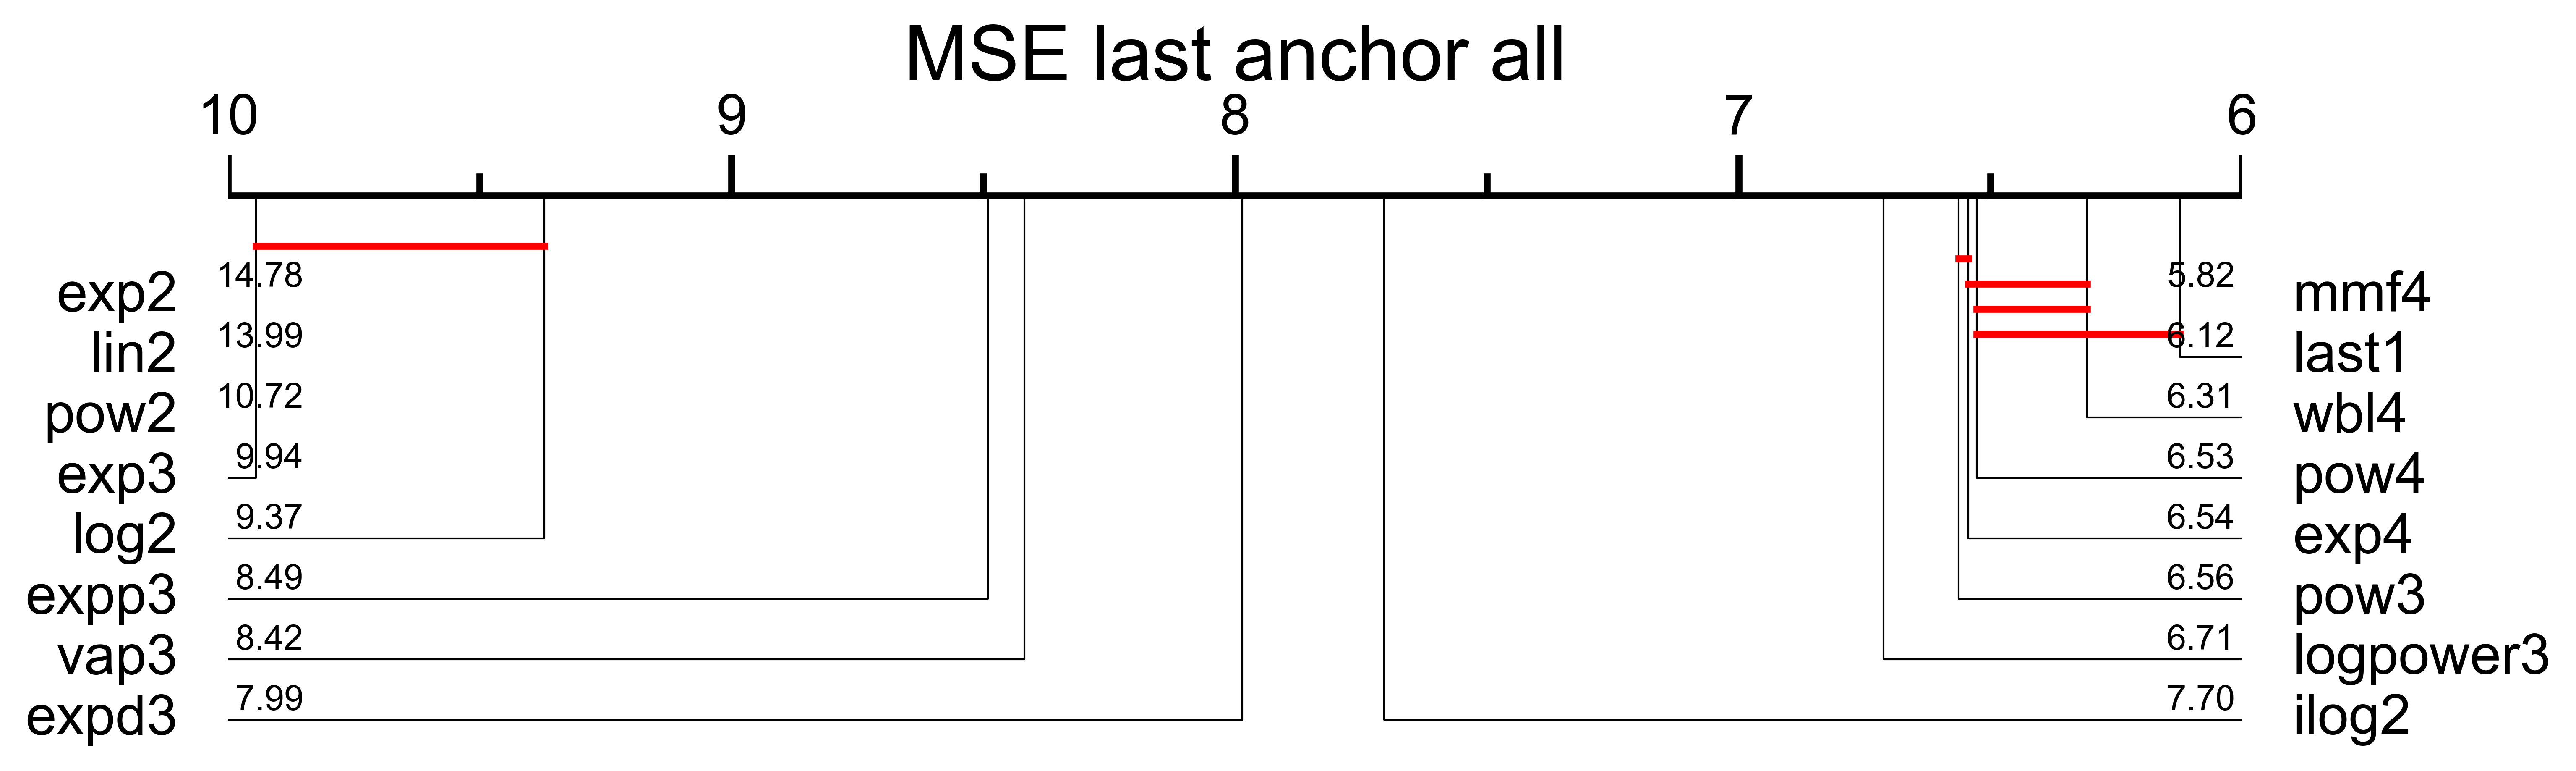

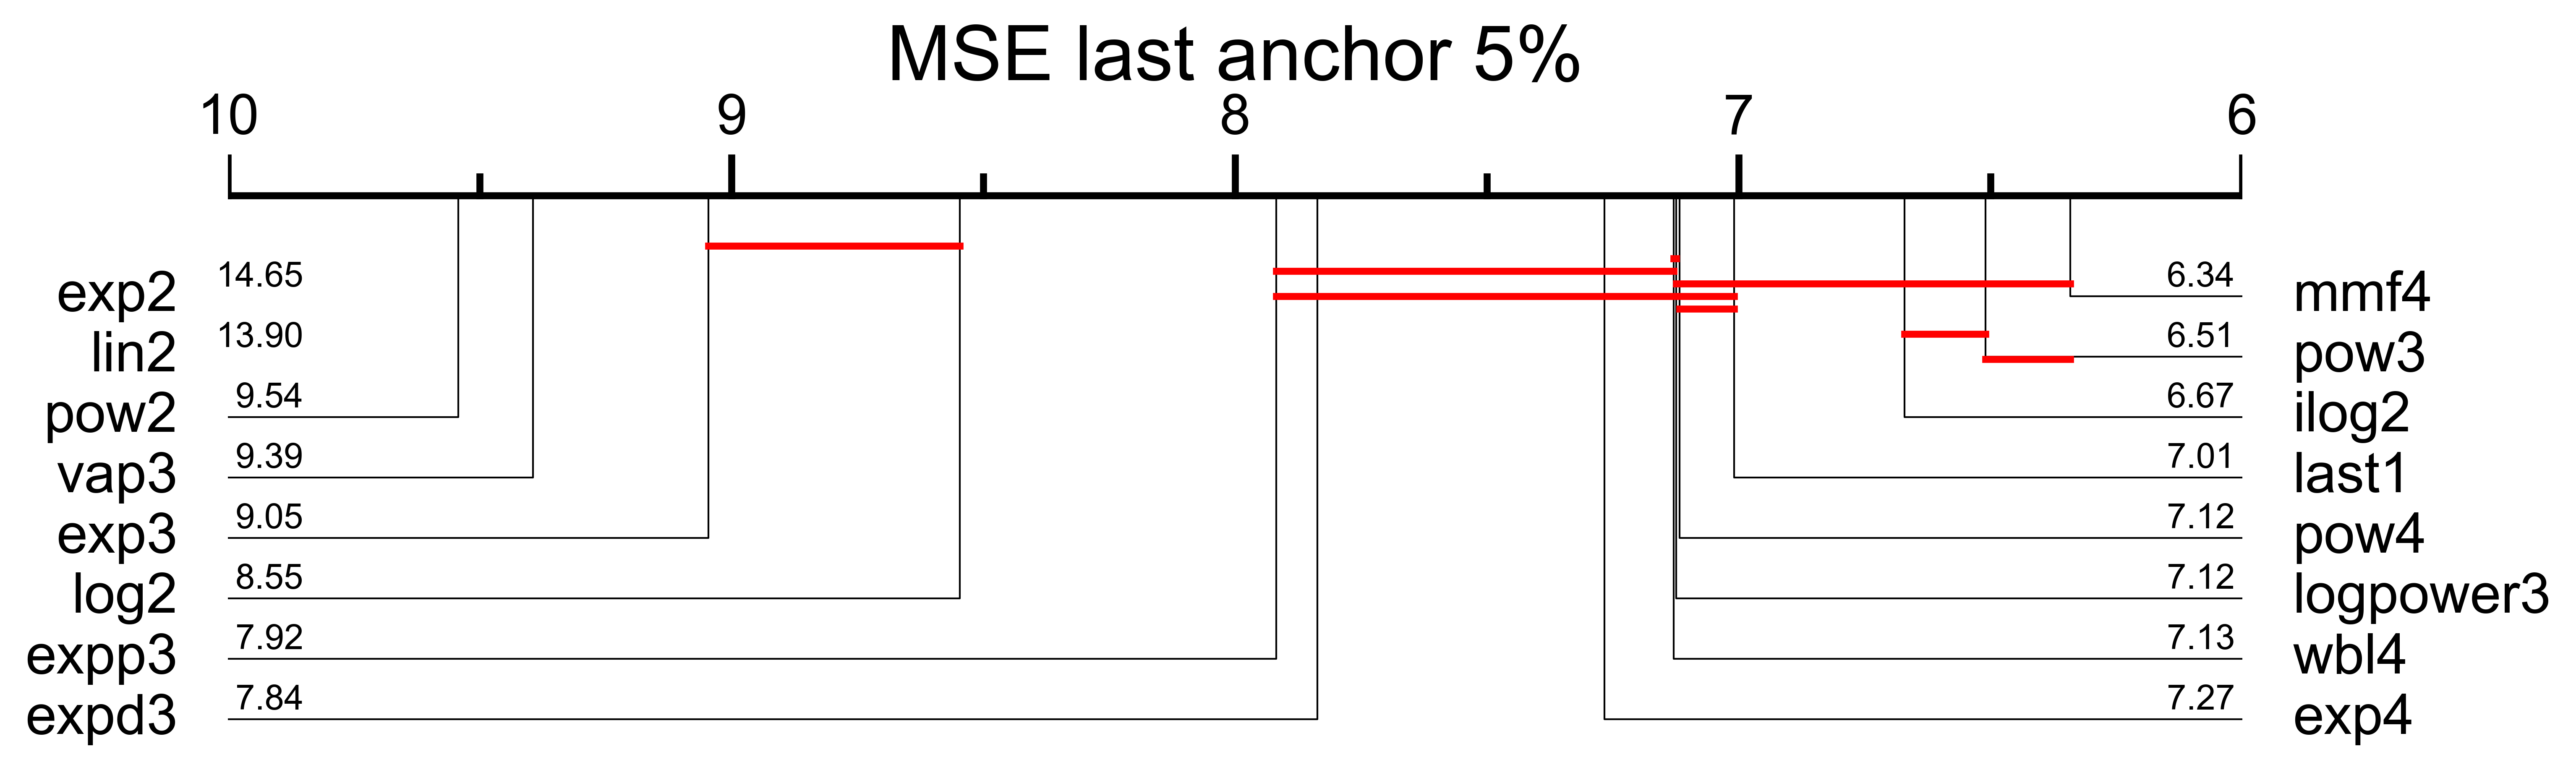

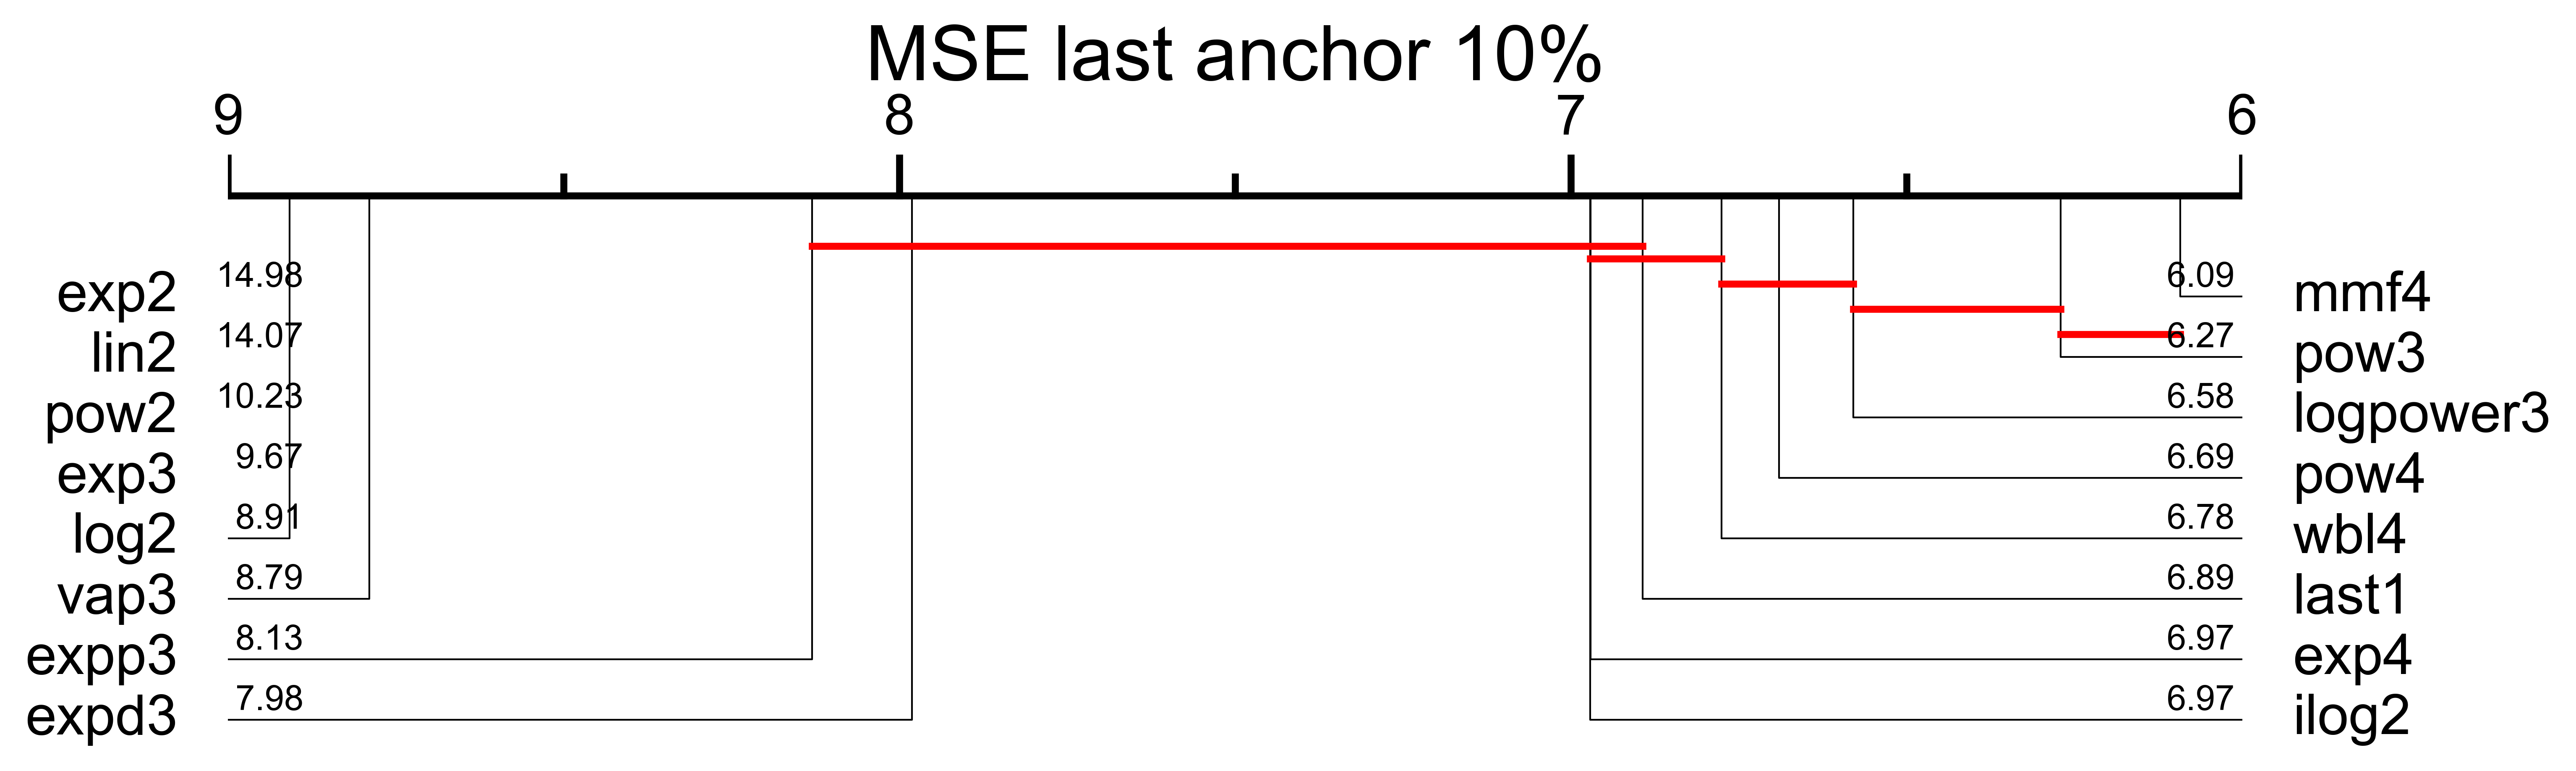

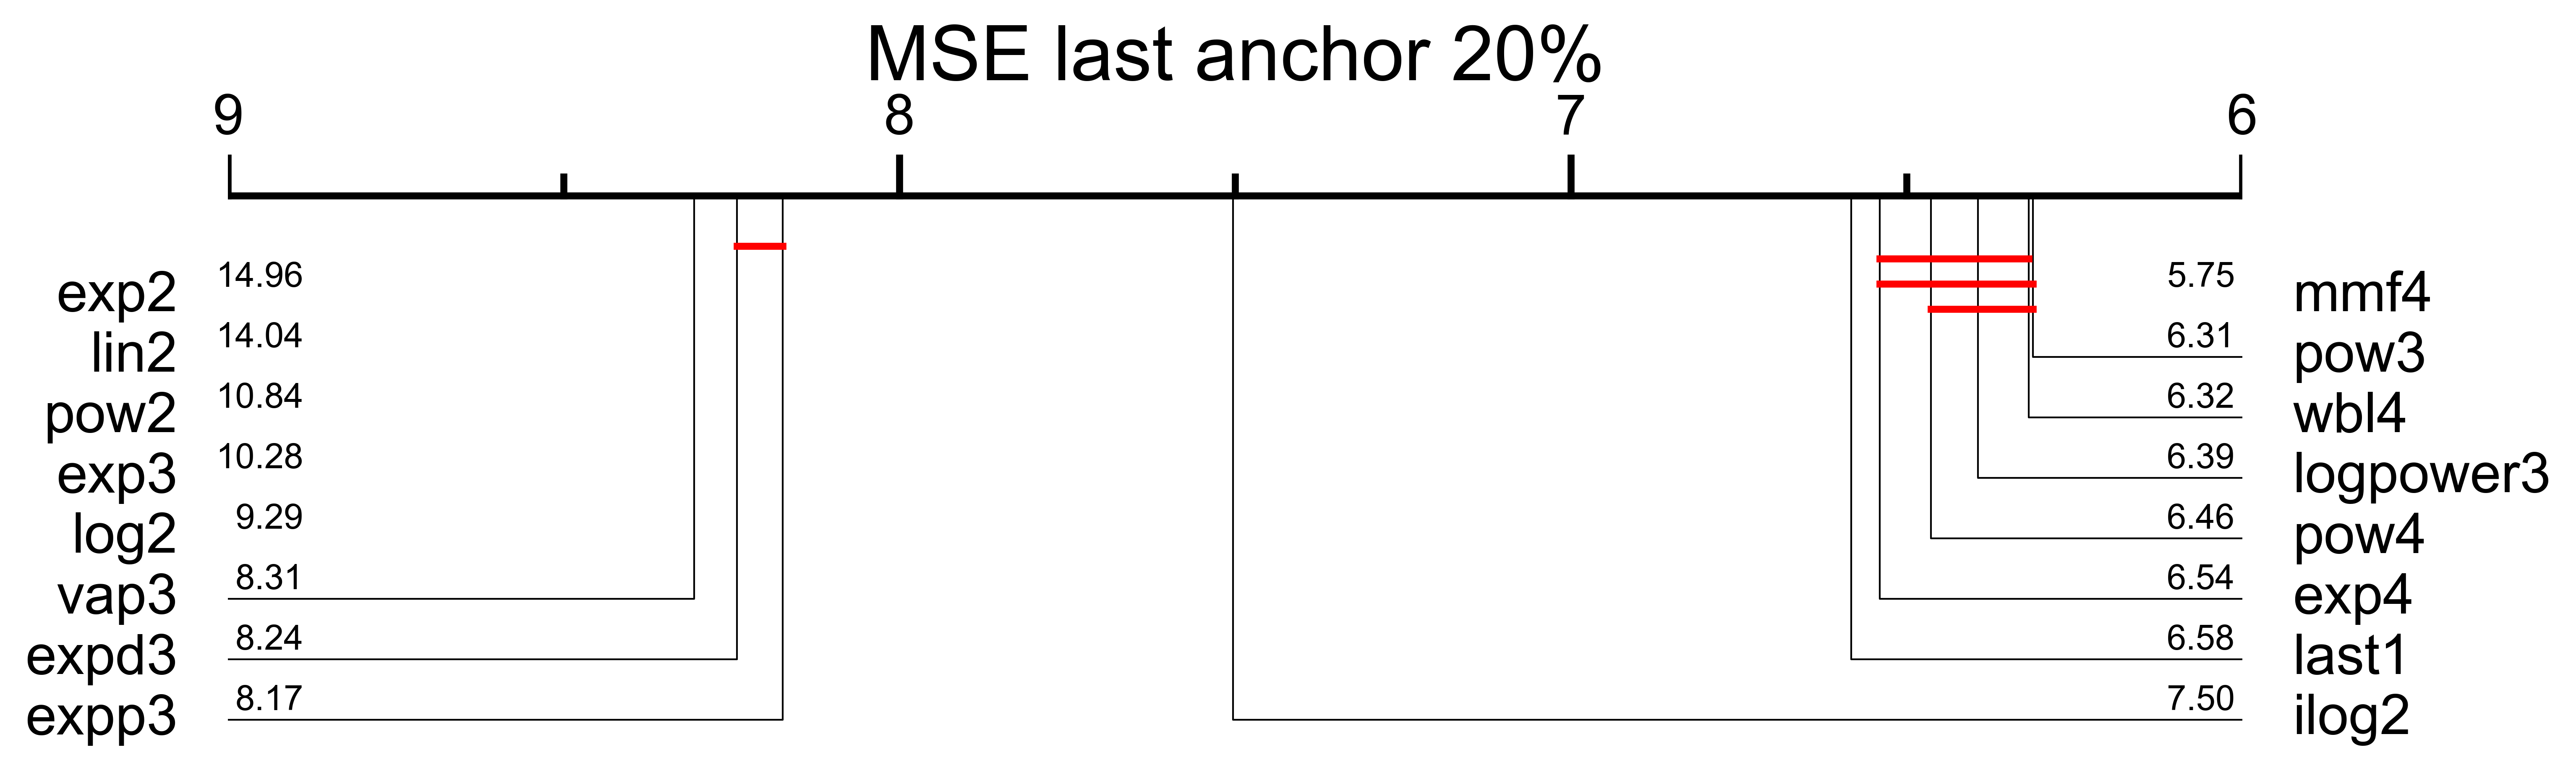

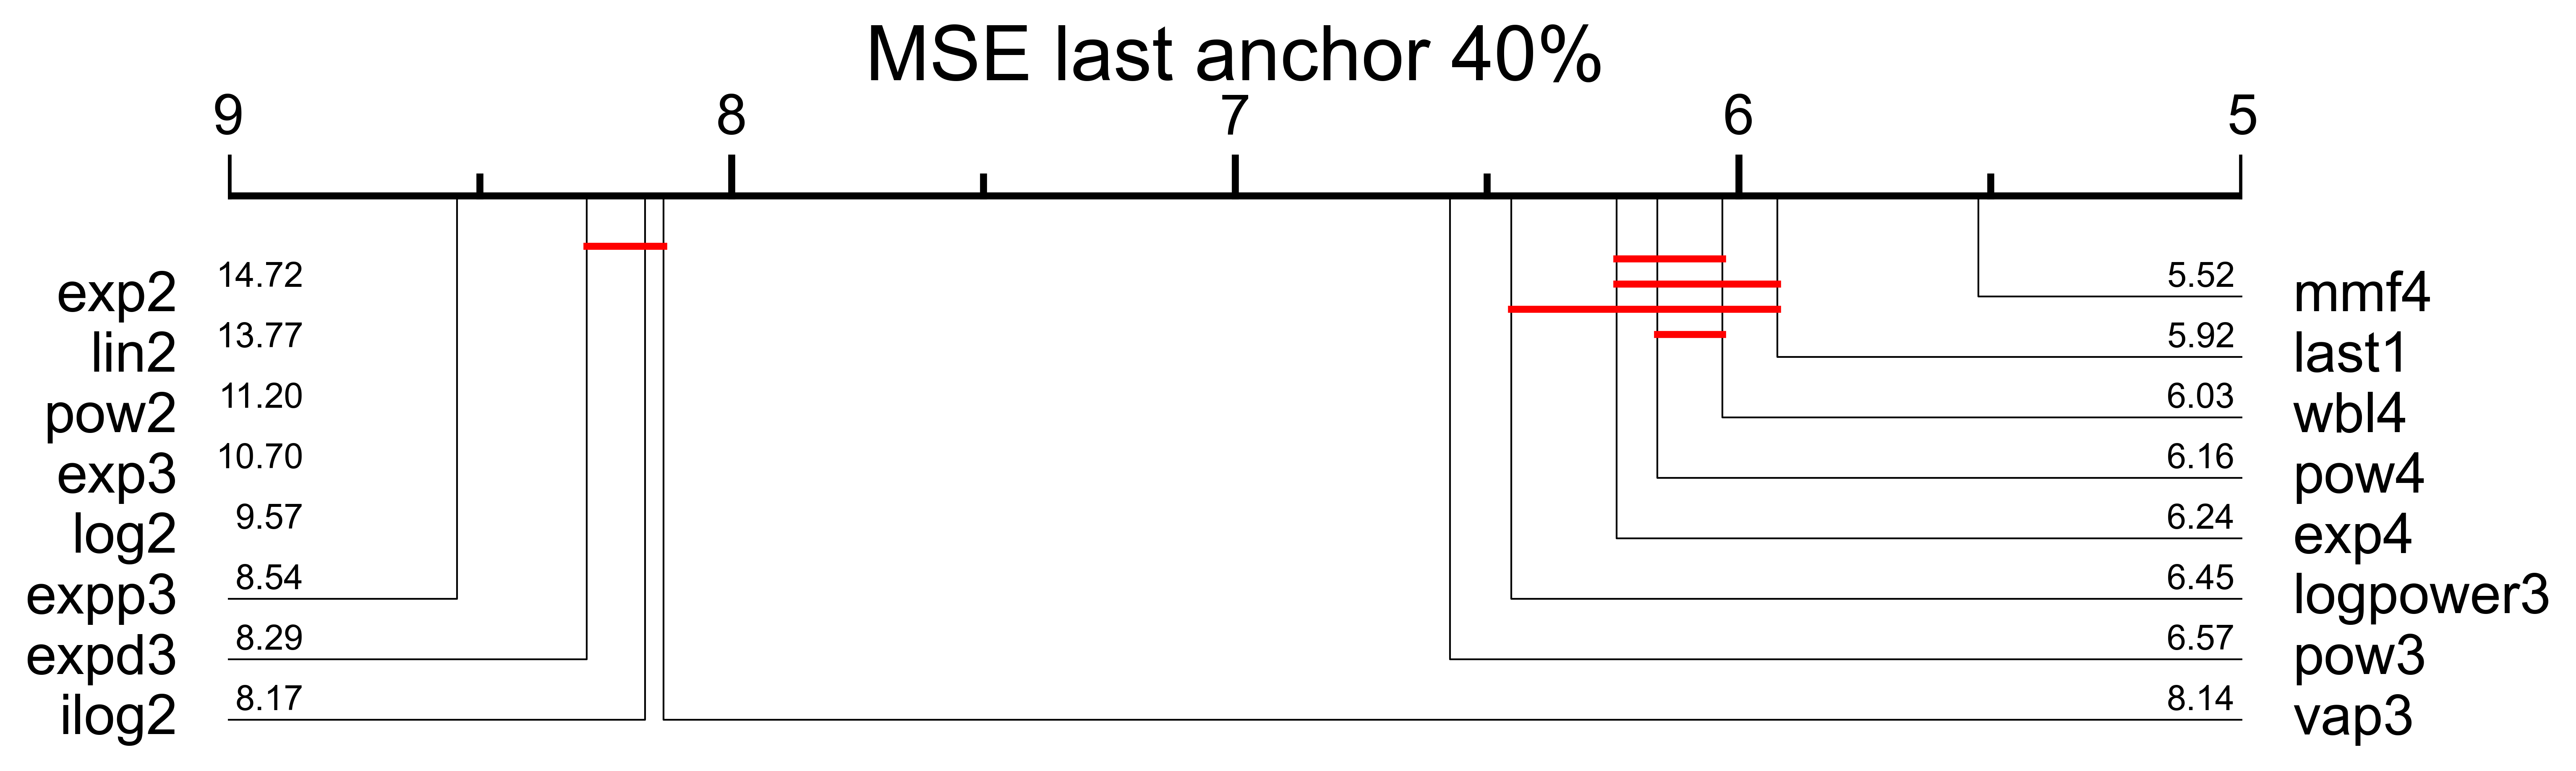

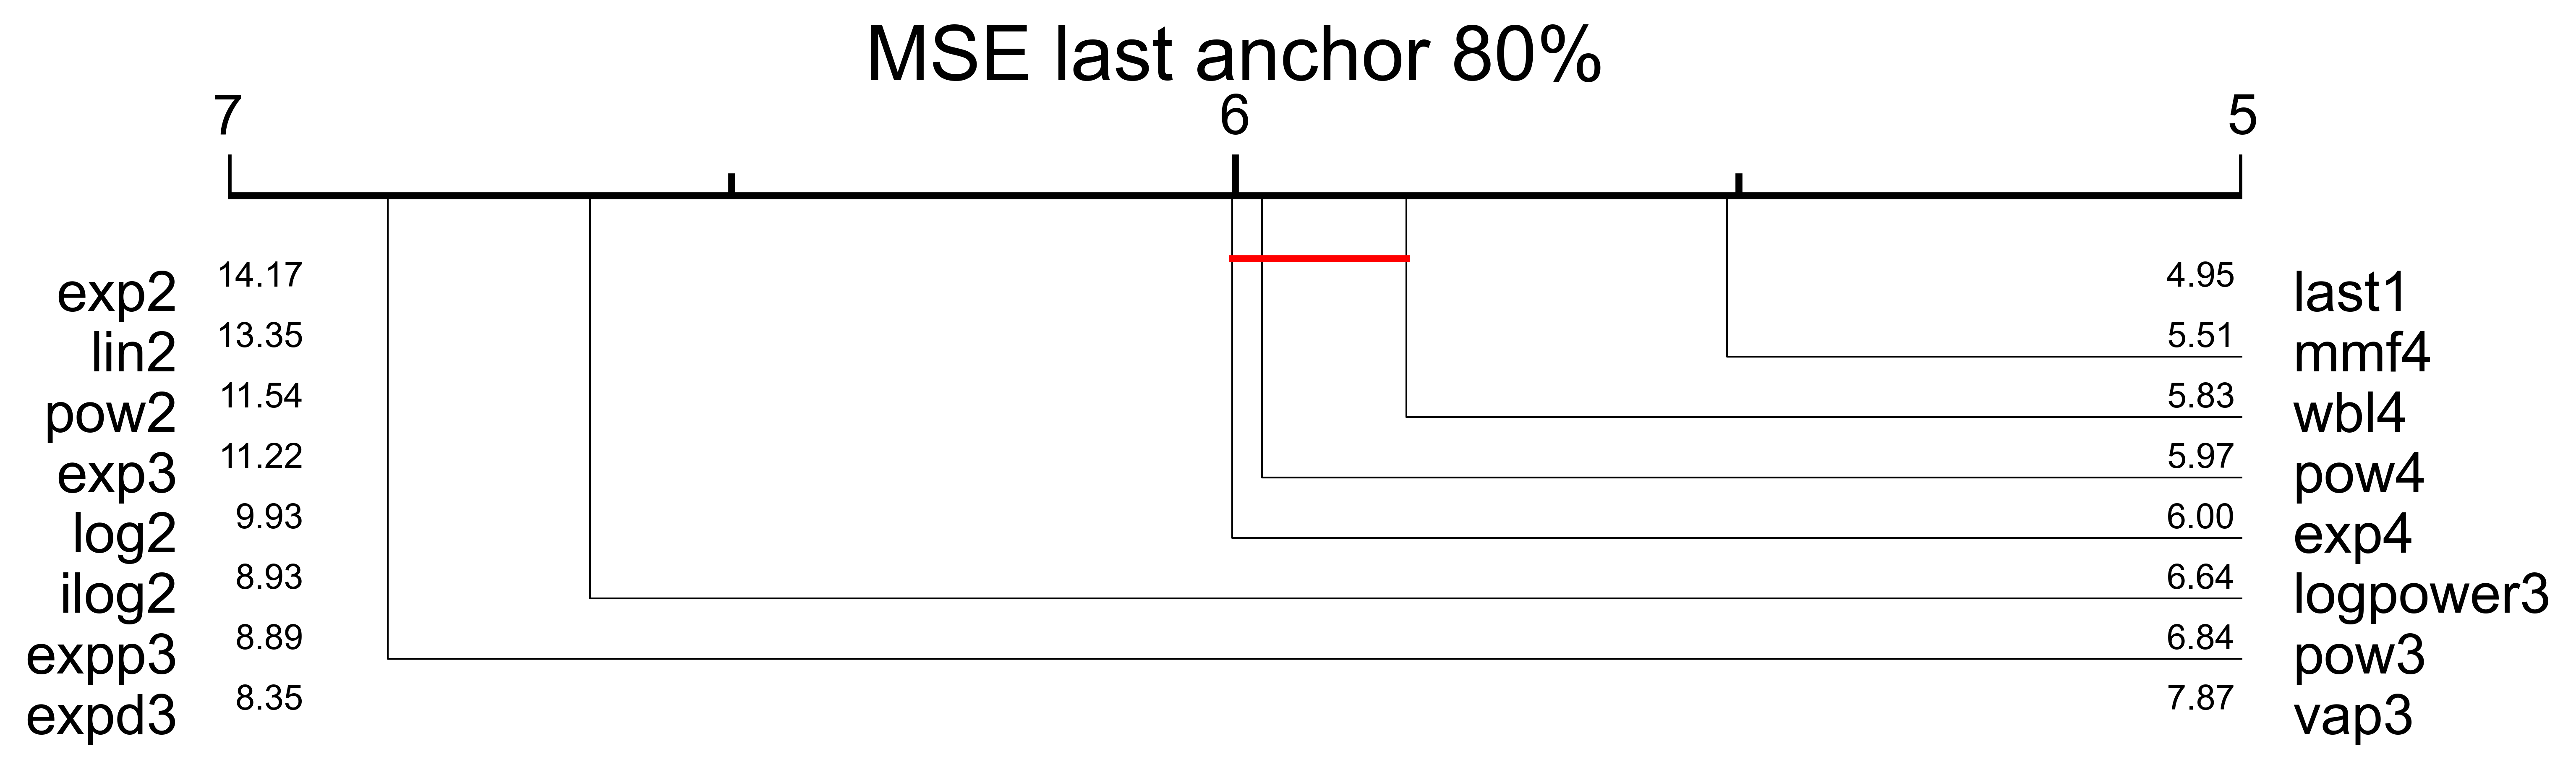

In [24]:
make_all_cd_plots(tables_MSE_tst_last,tables_MSE_tst_last_nan,'MSE last anchor','.eps')

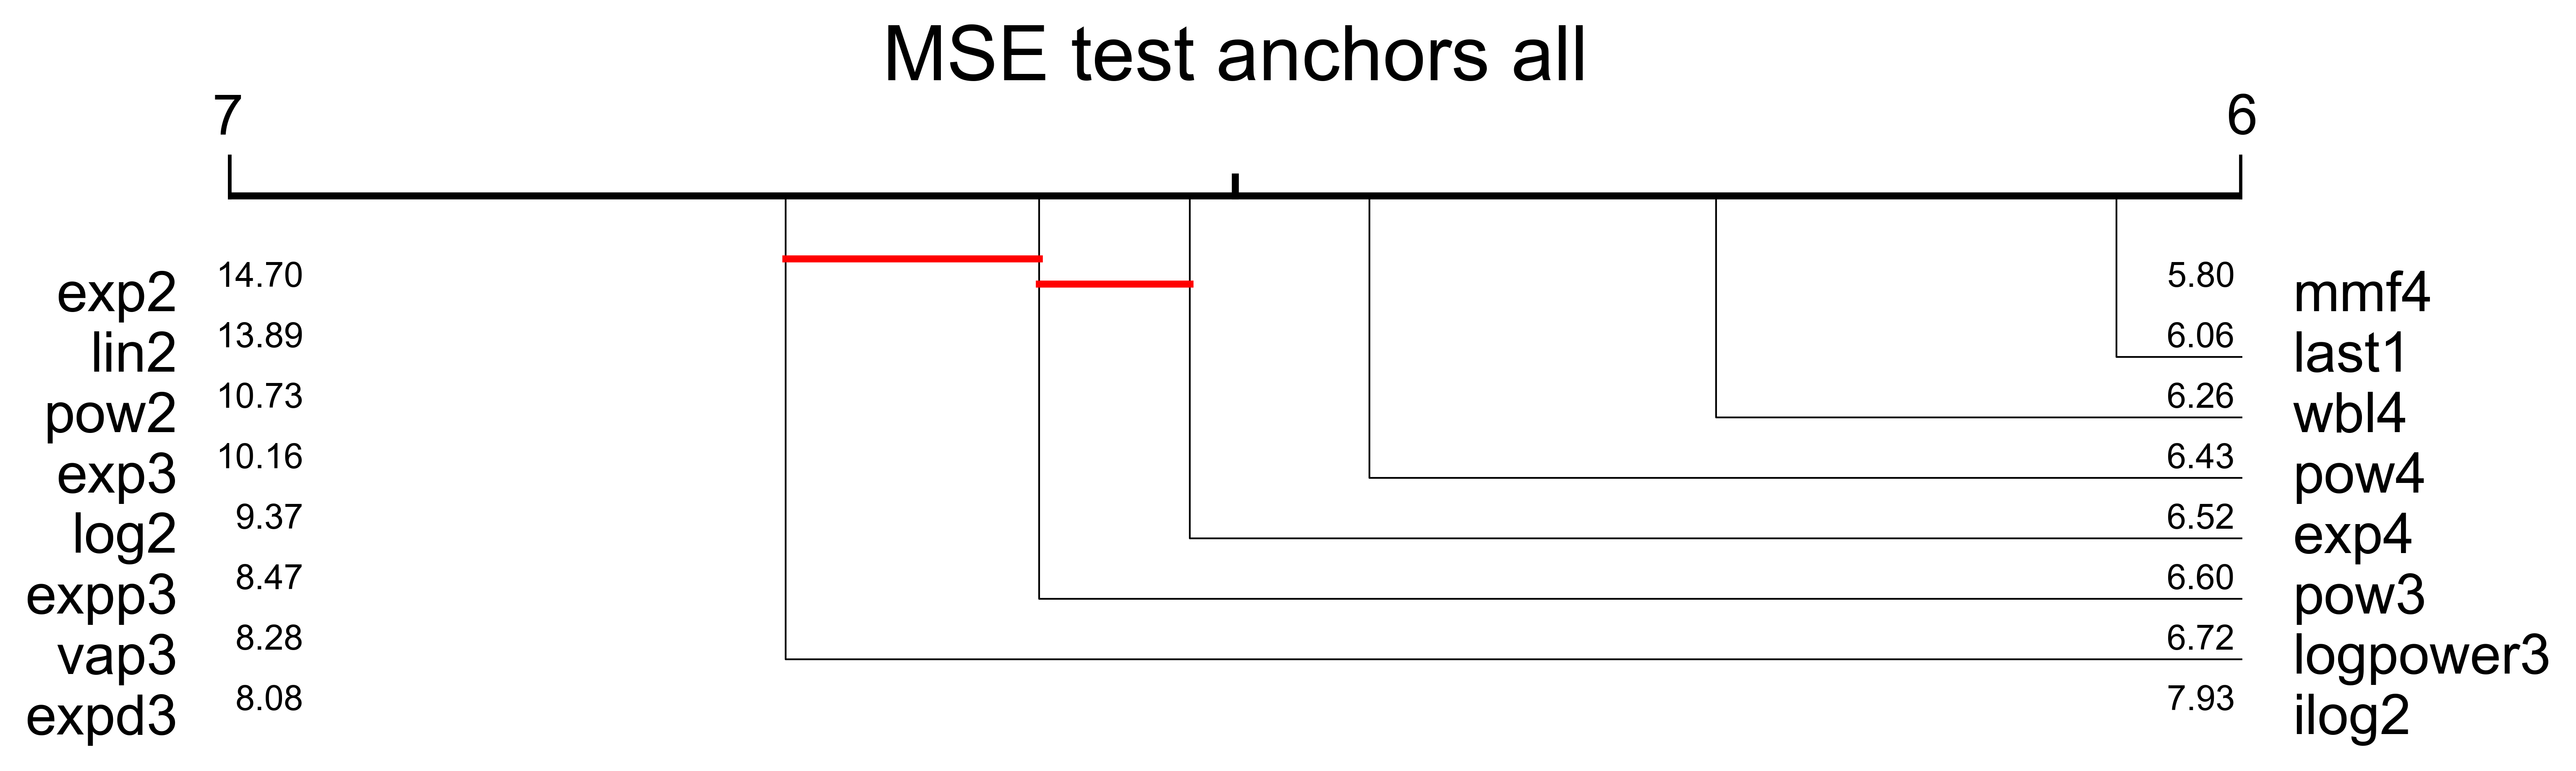

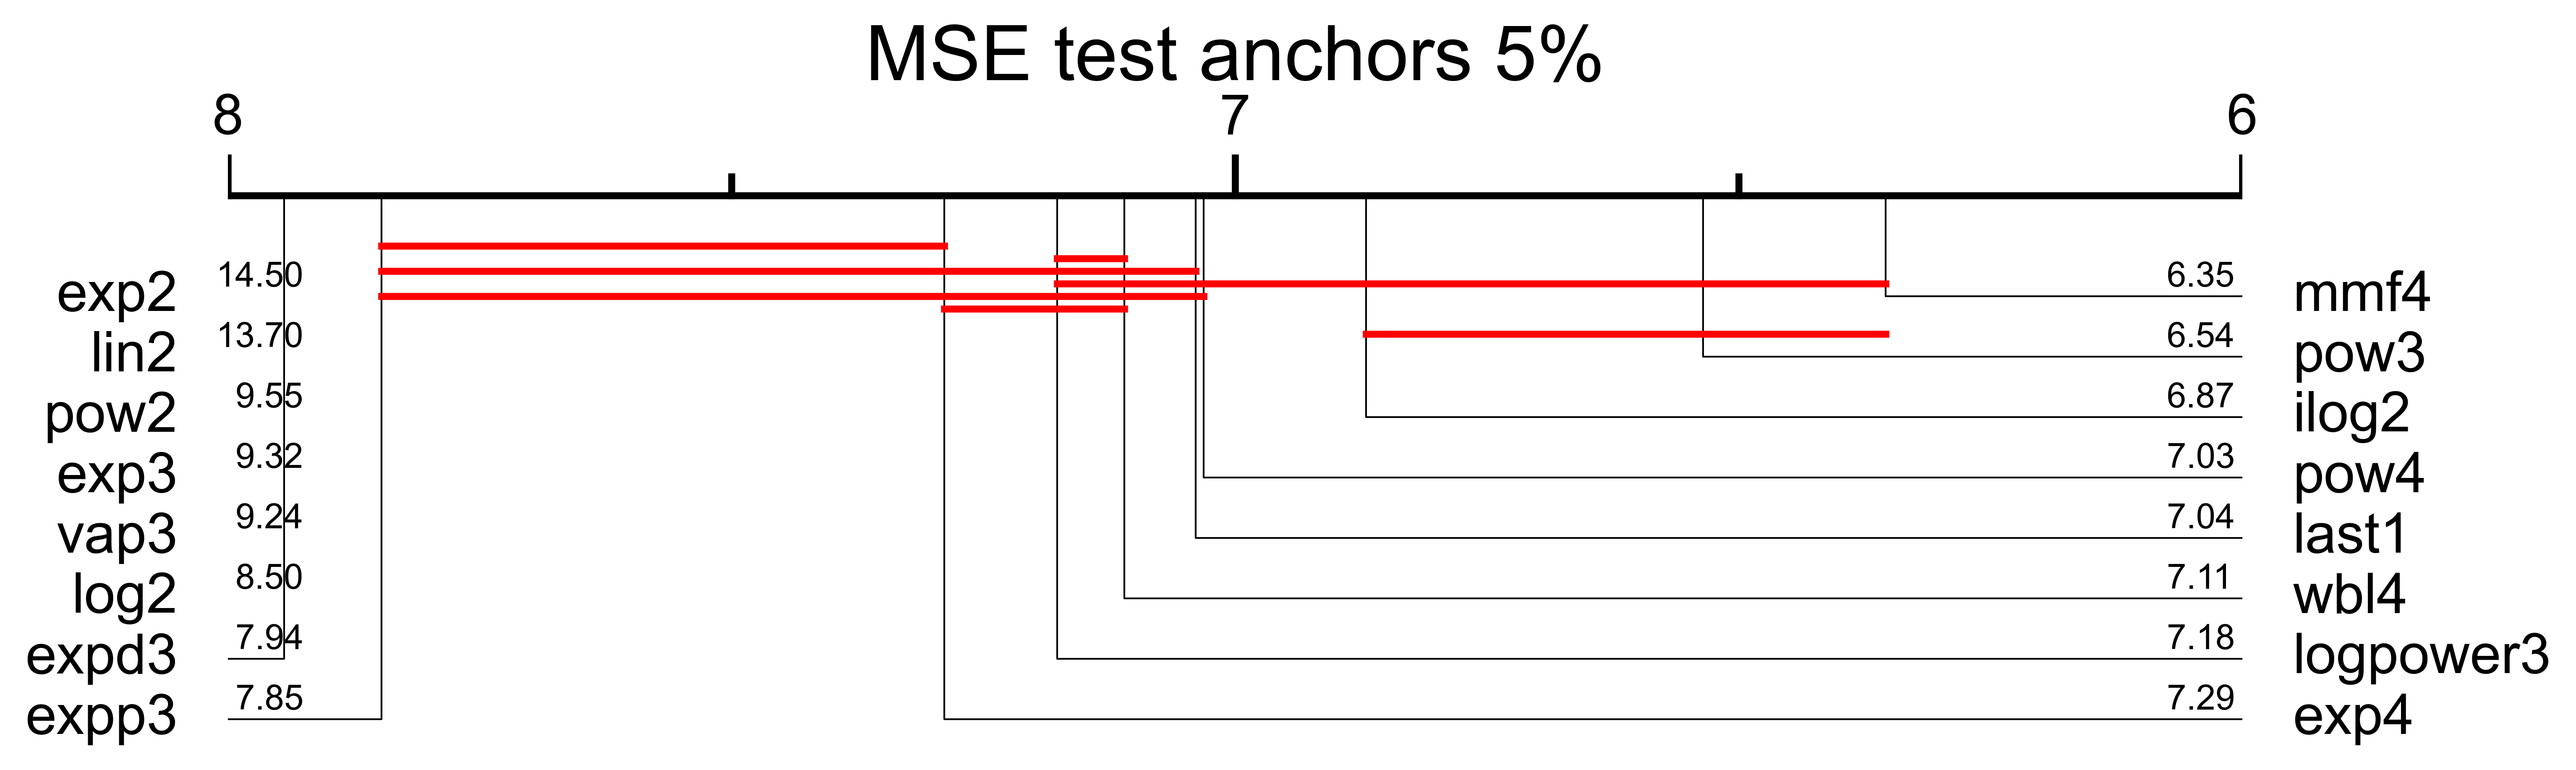

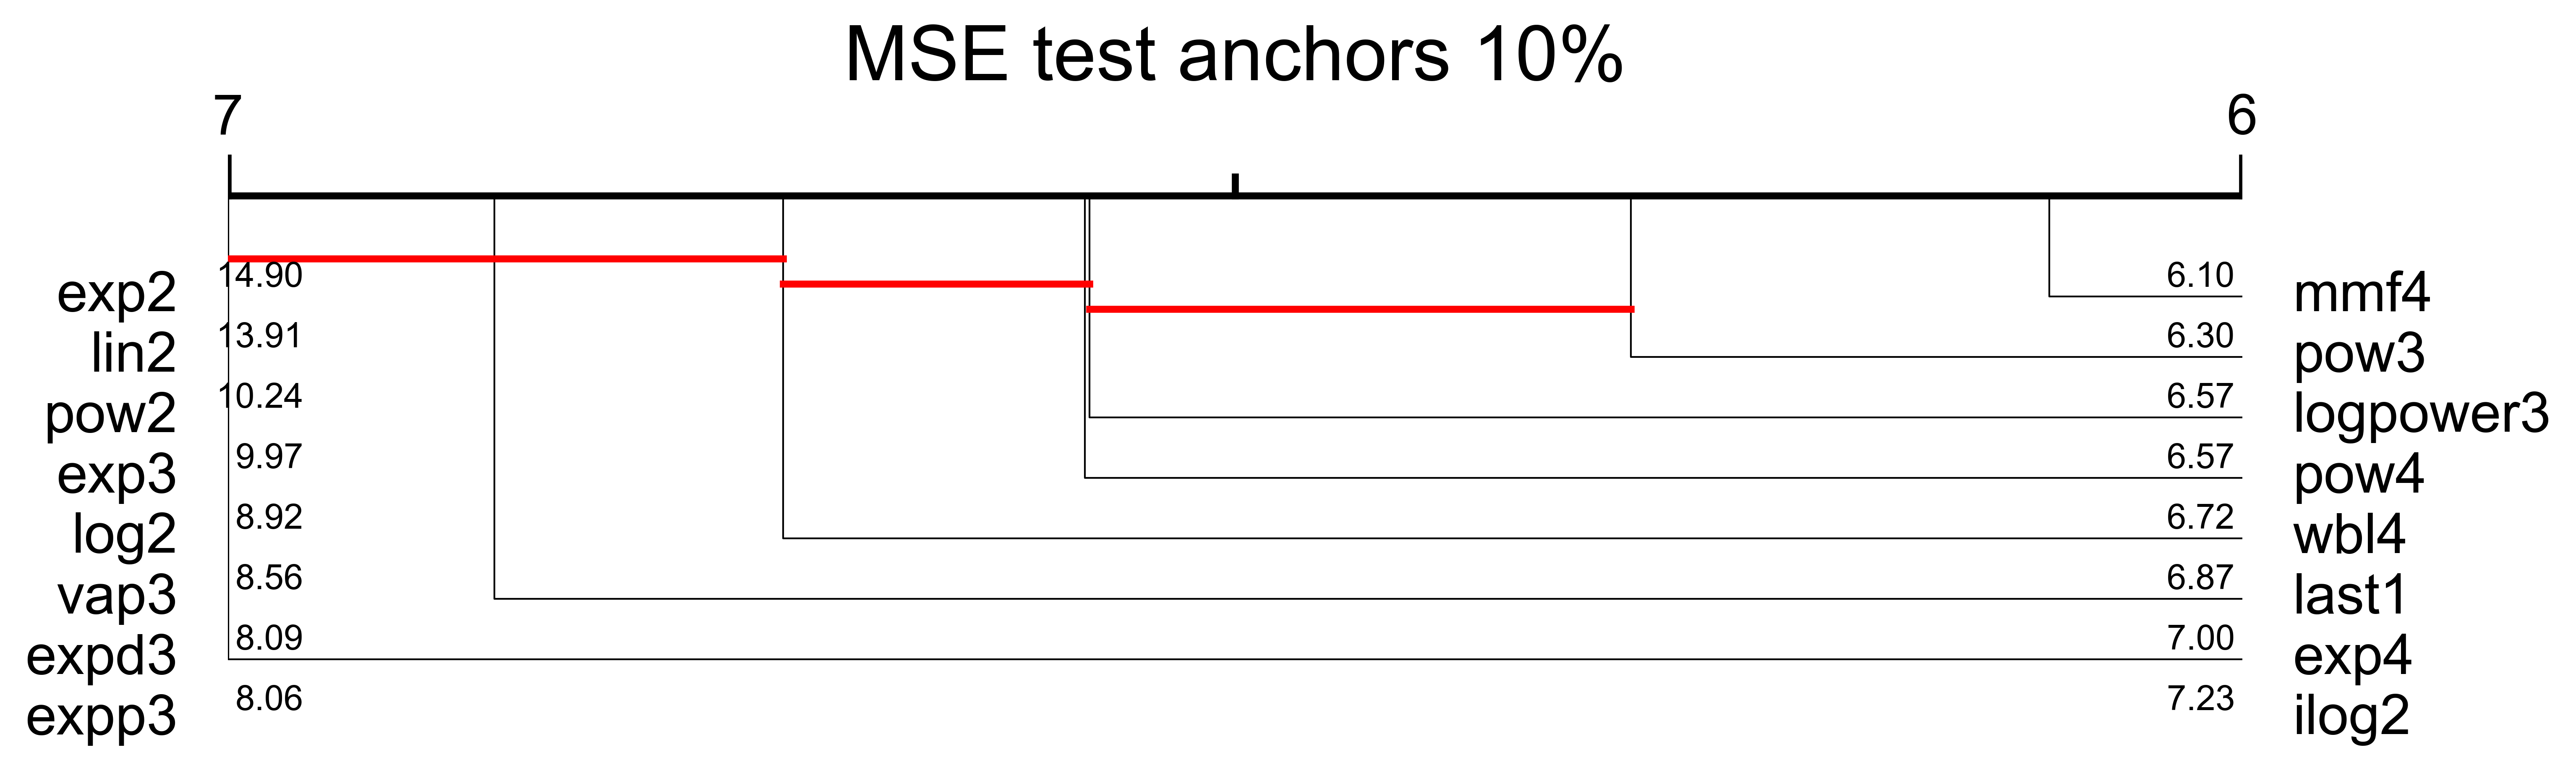

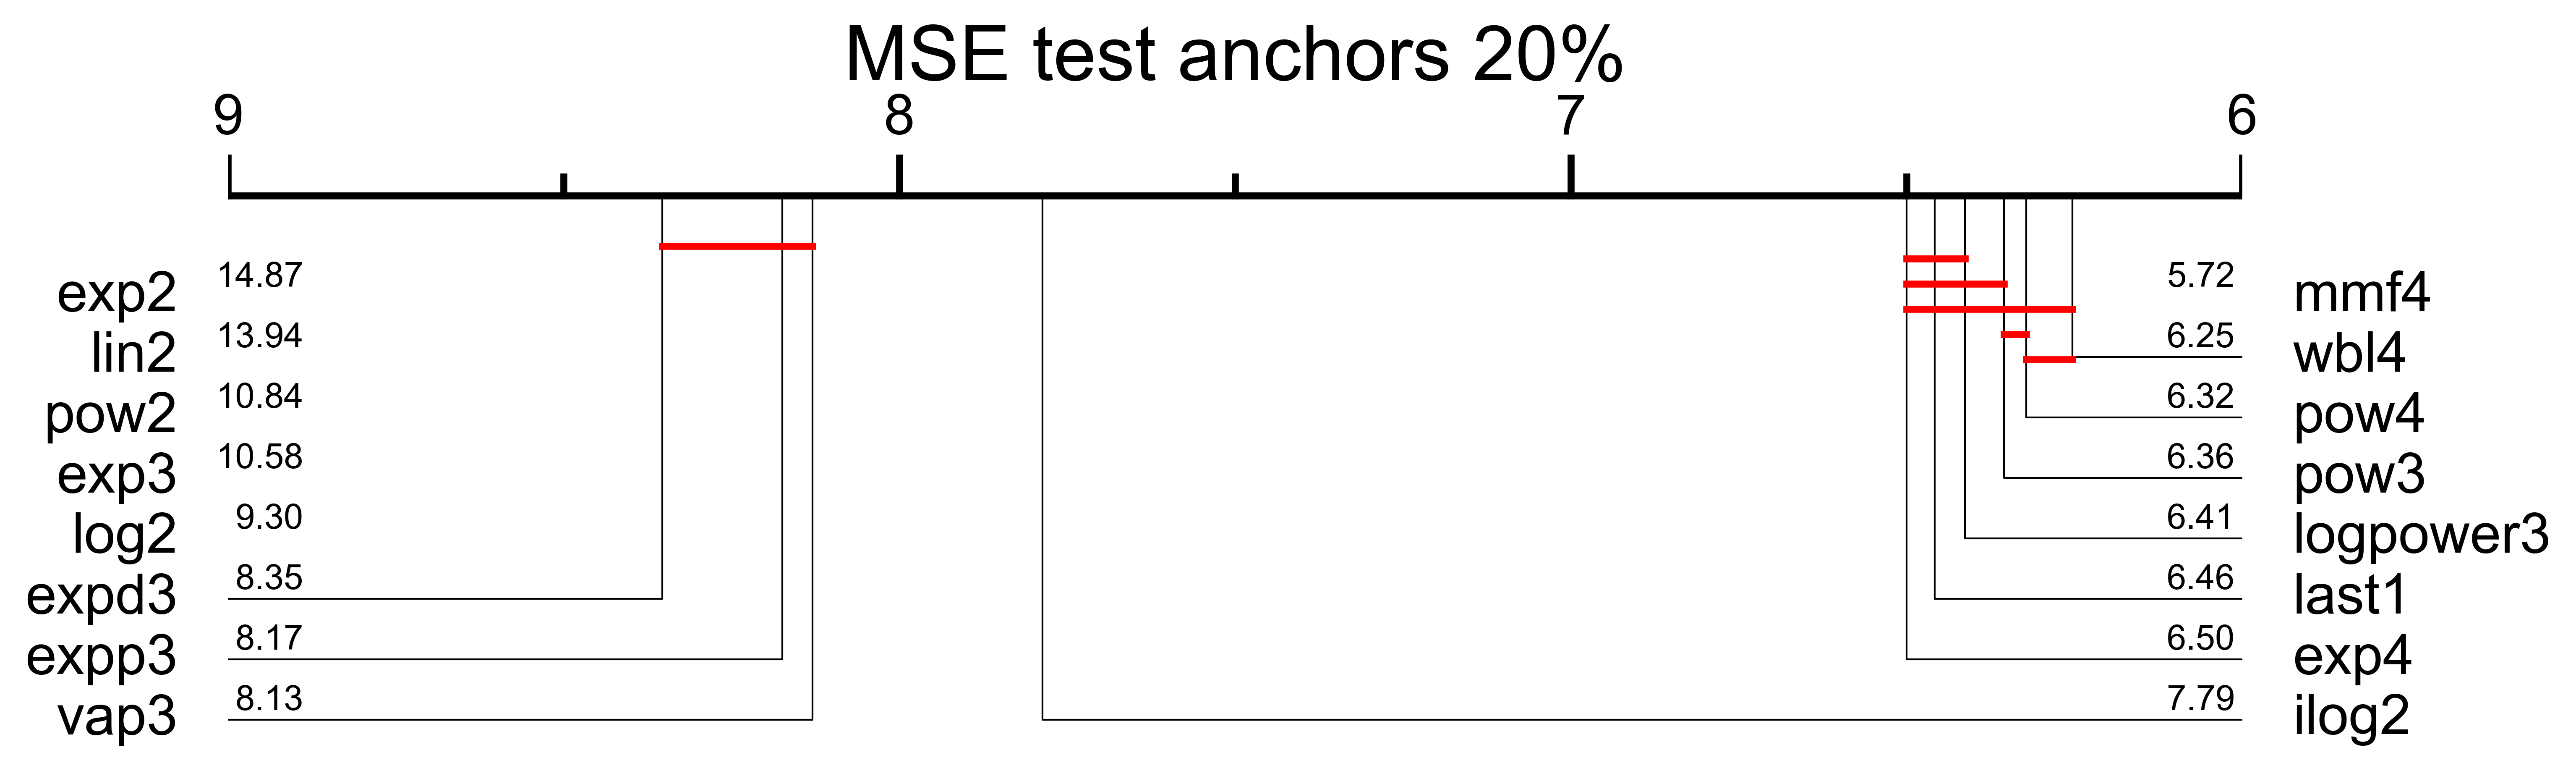

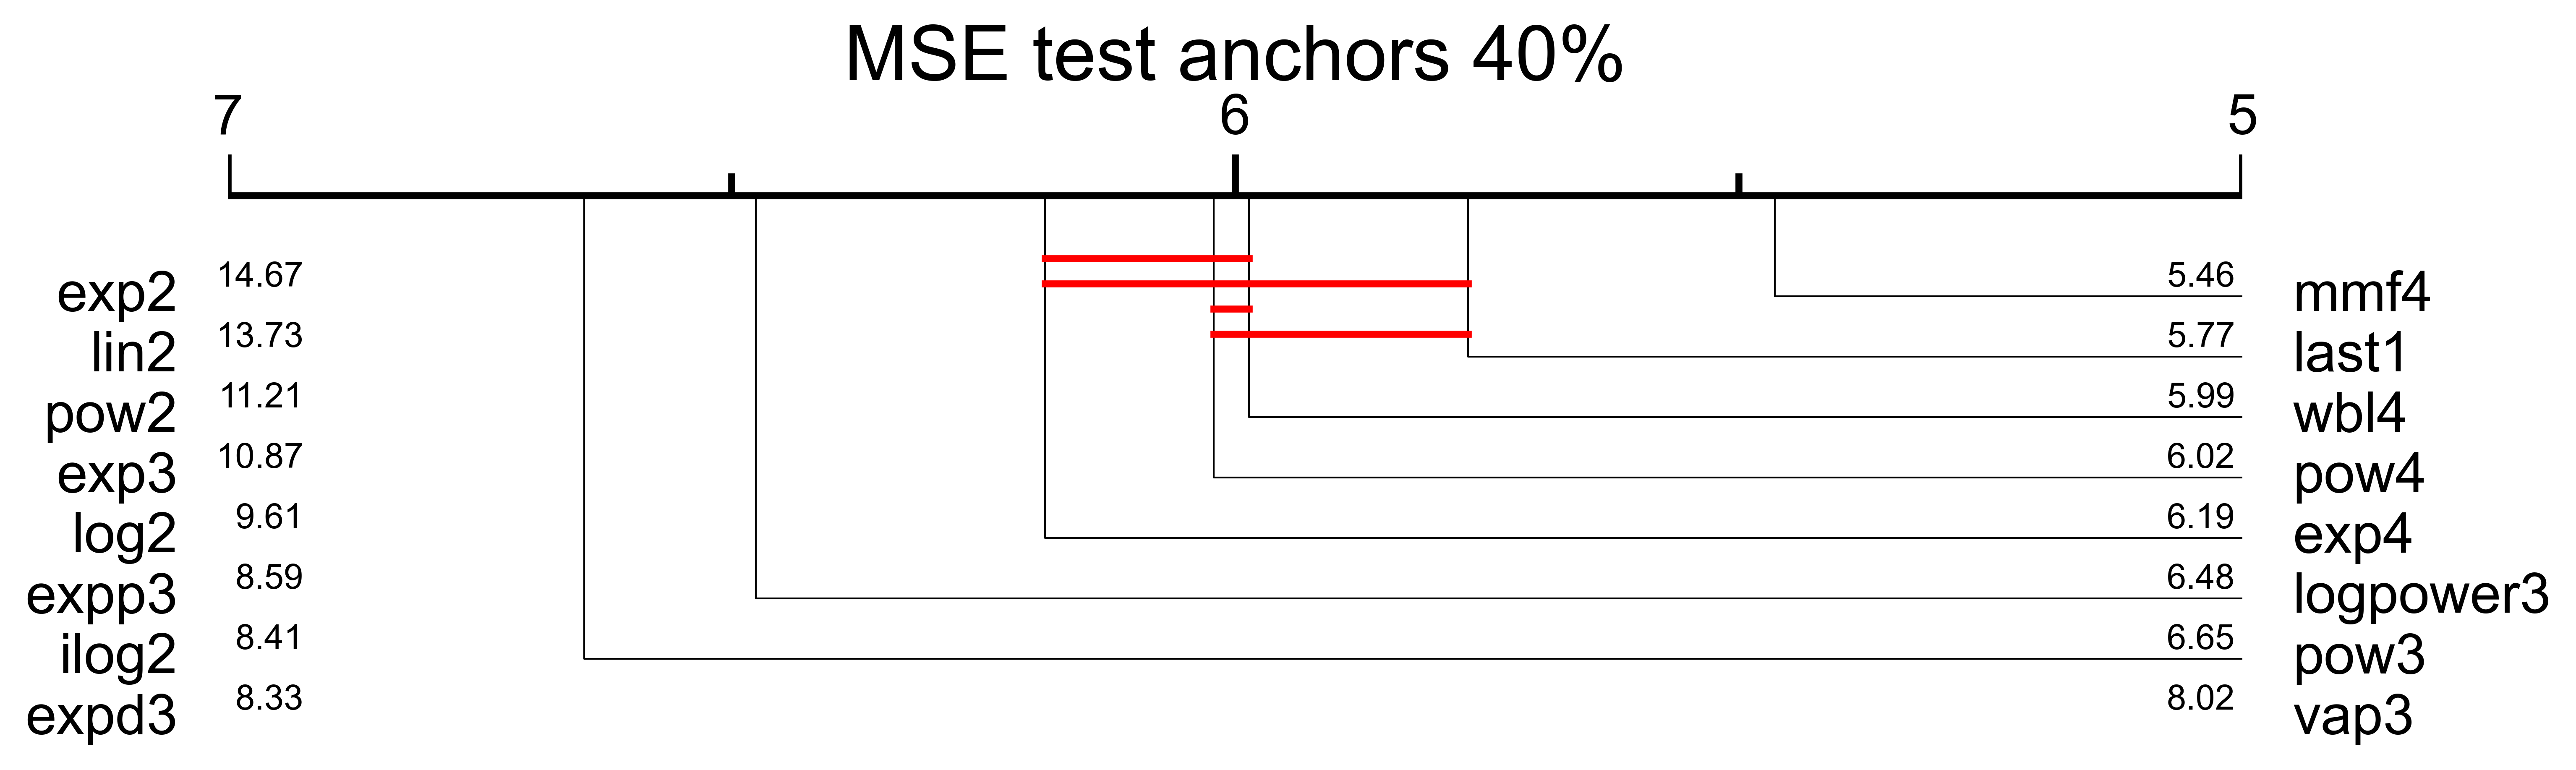

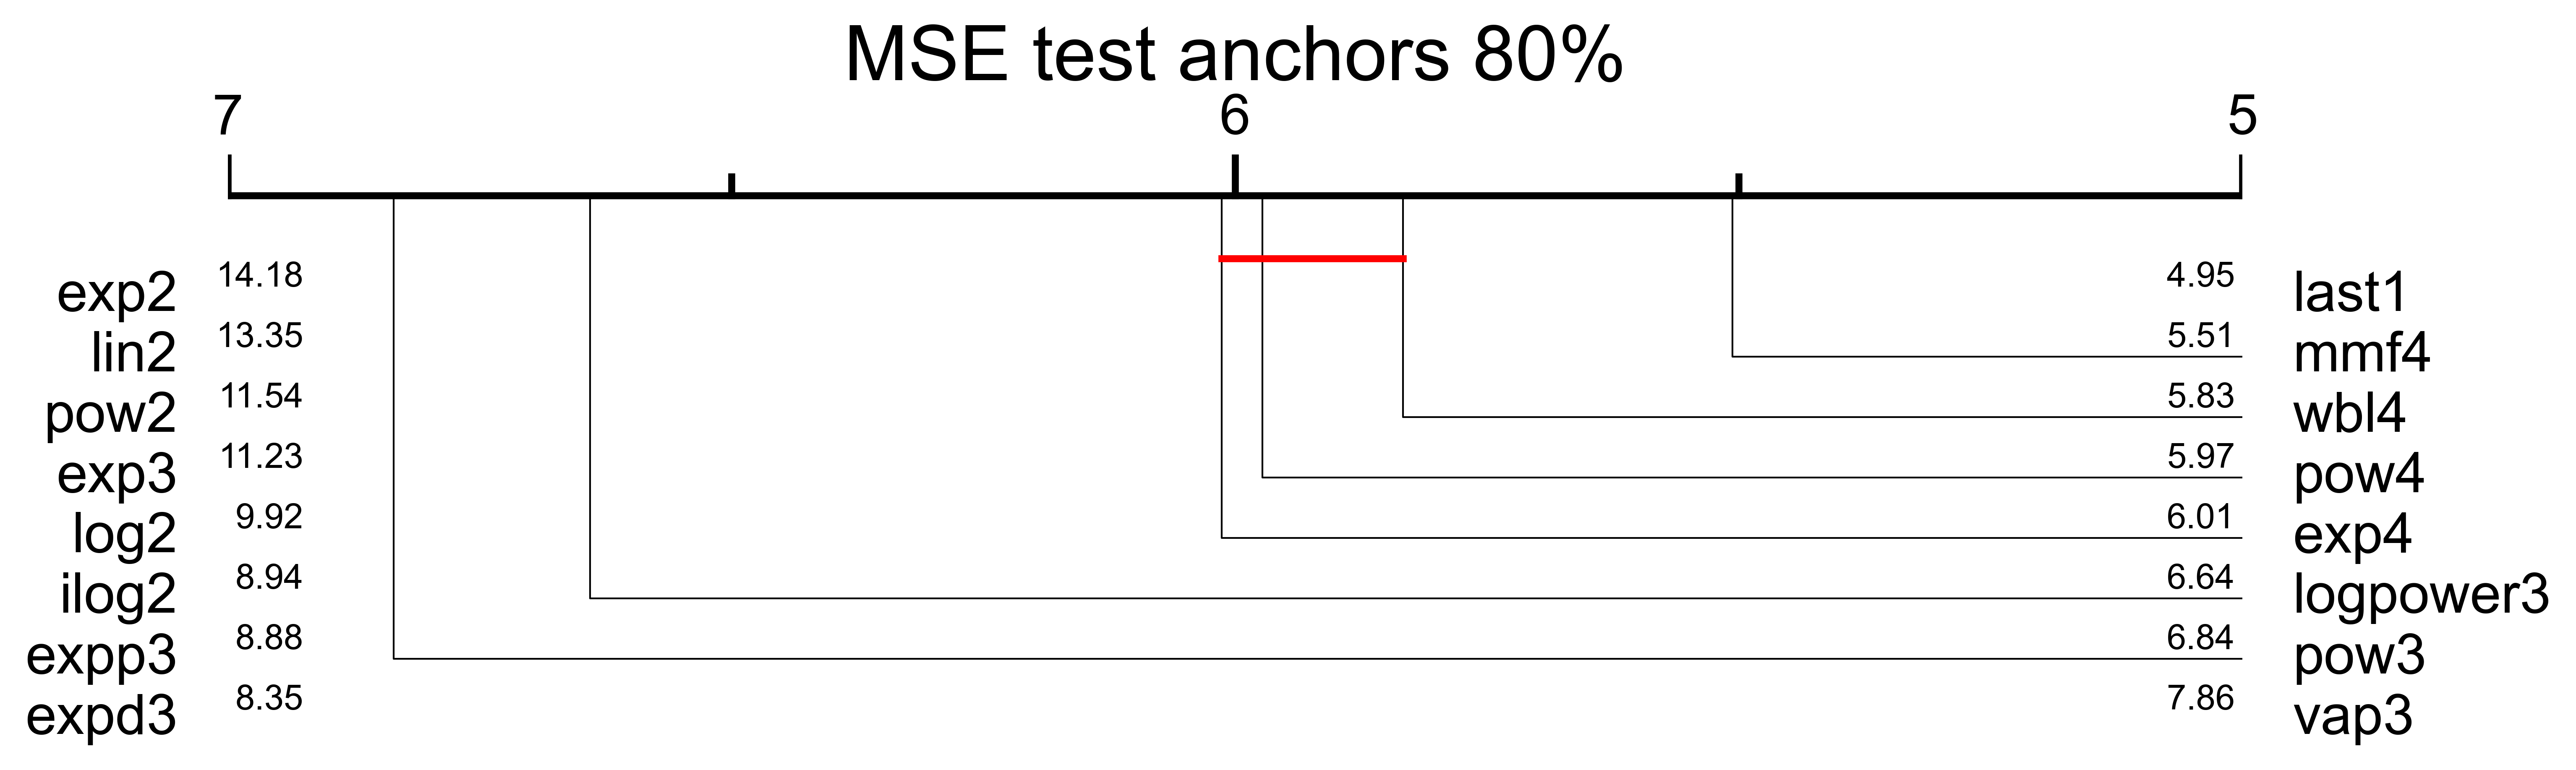

In [25]:
make_all_cd_plots(tables_MSE_tst,tables_MSE_tst_nan,'MSE test anchors','.eps')

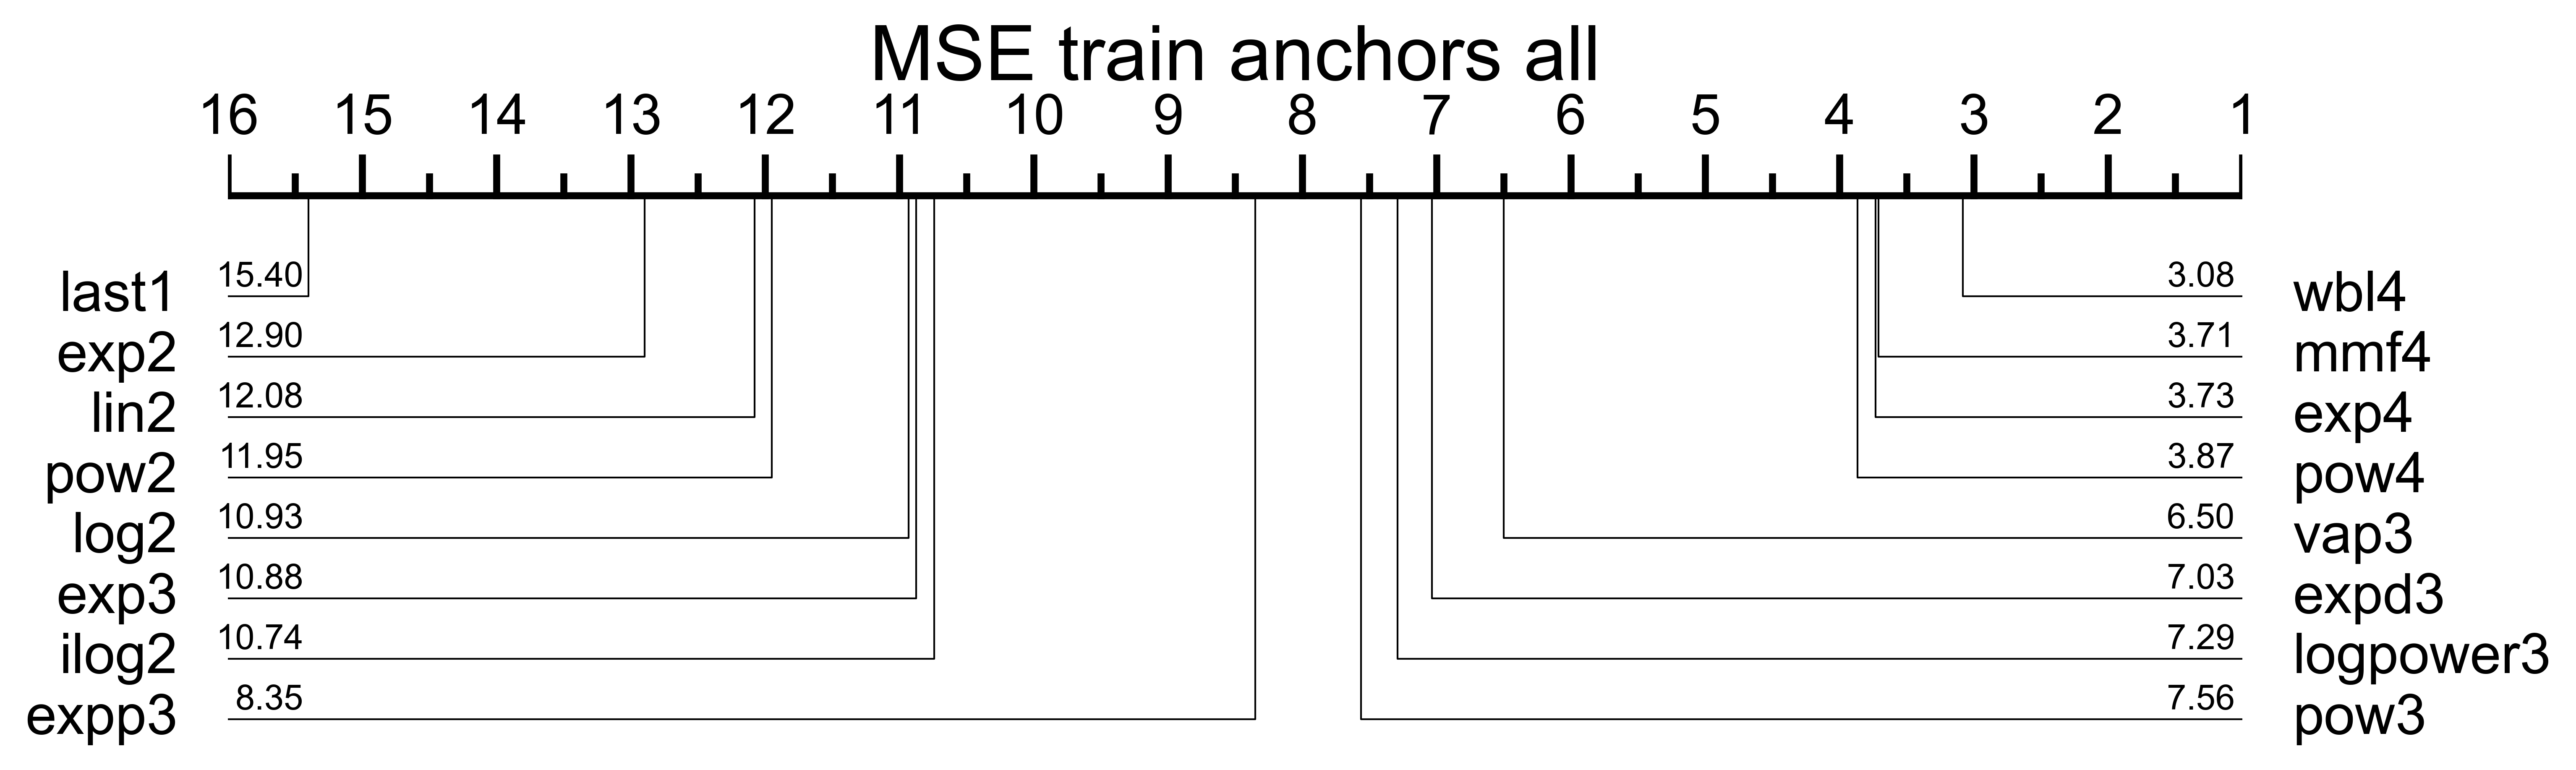

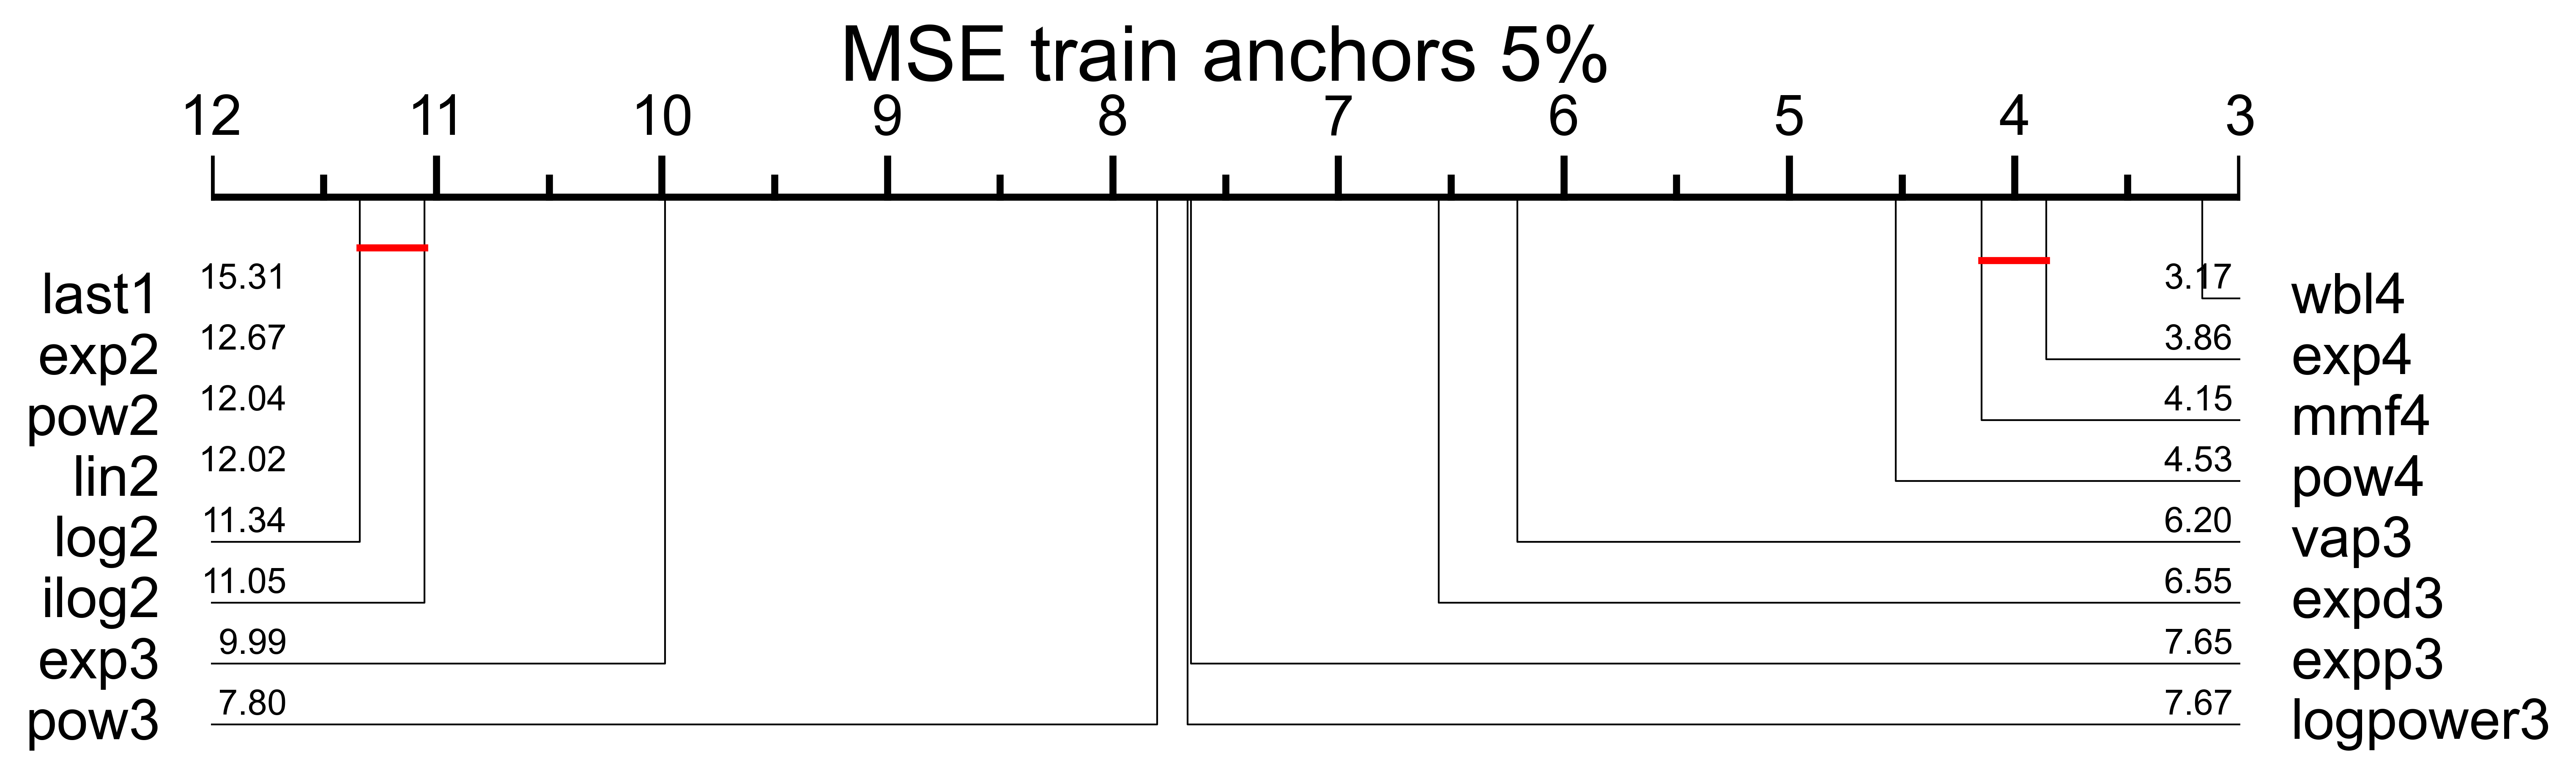

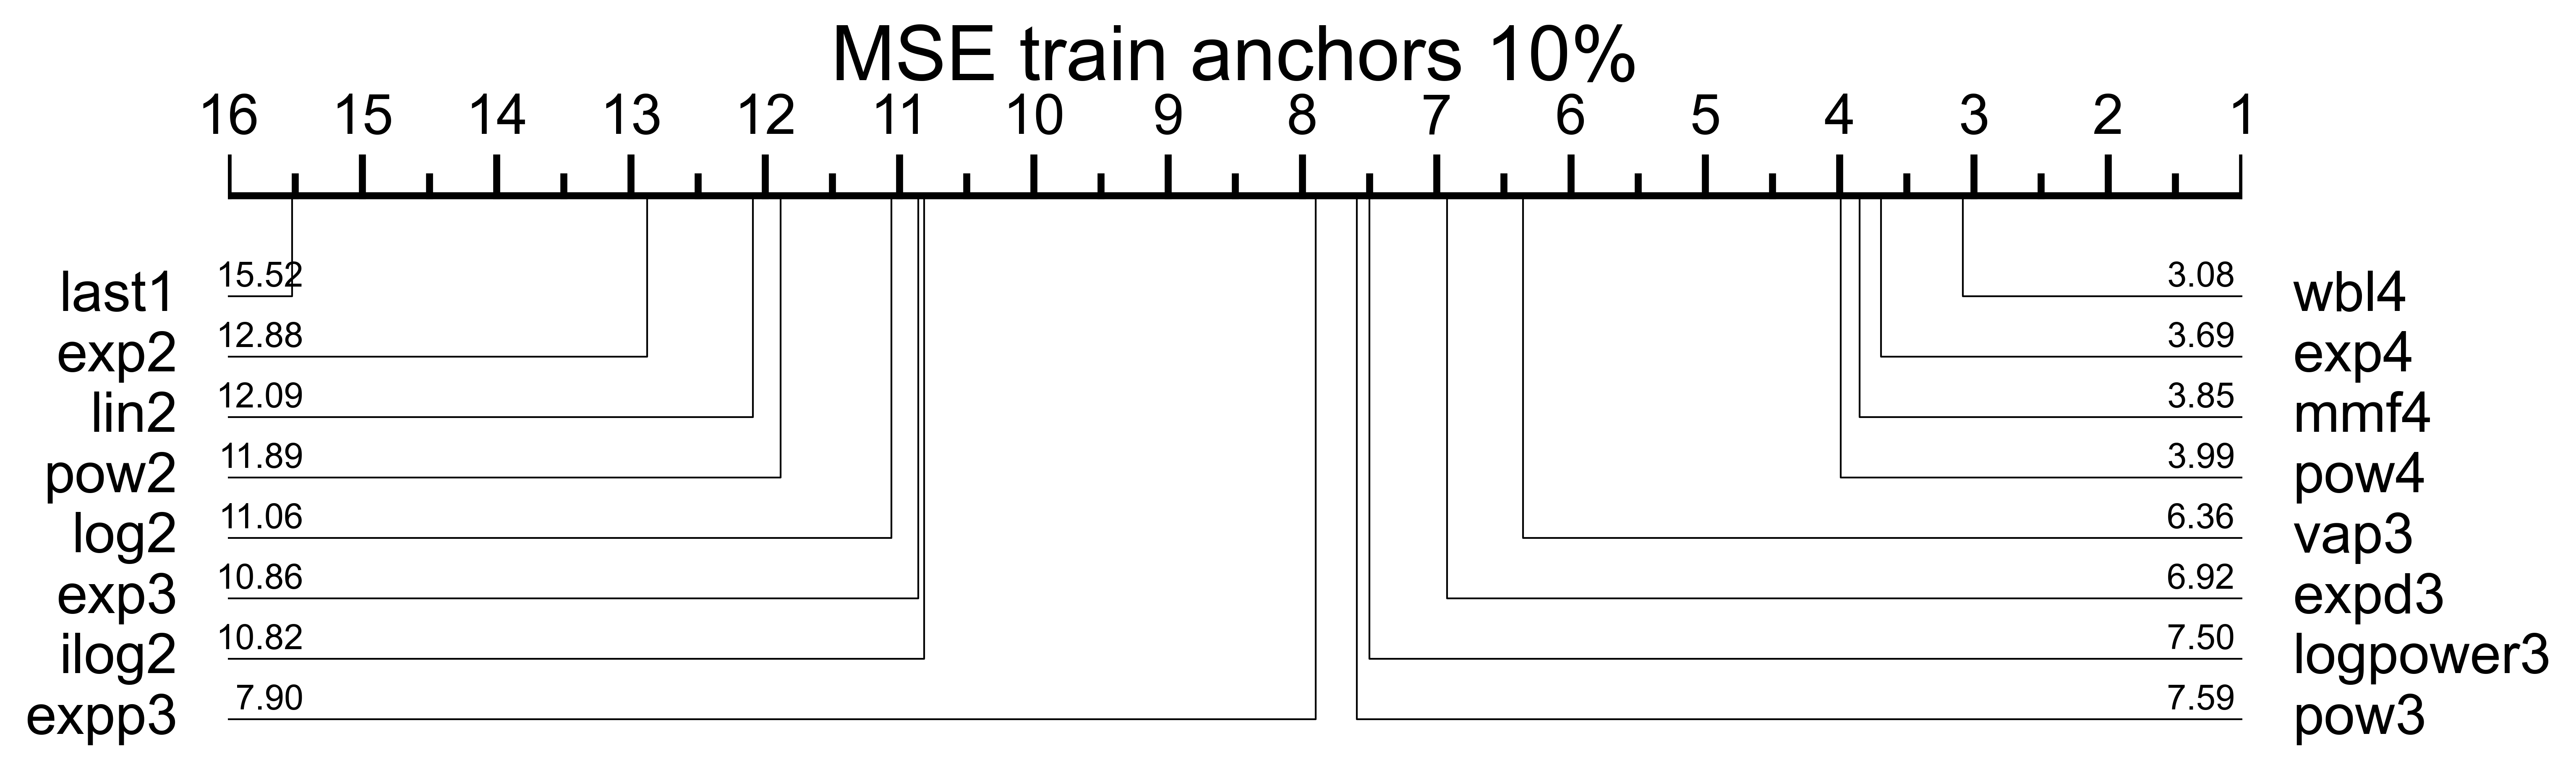

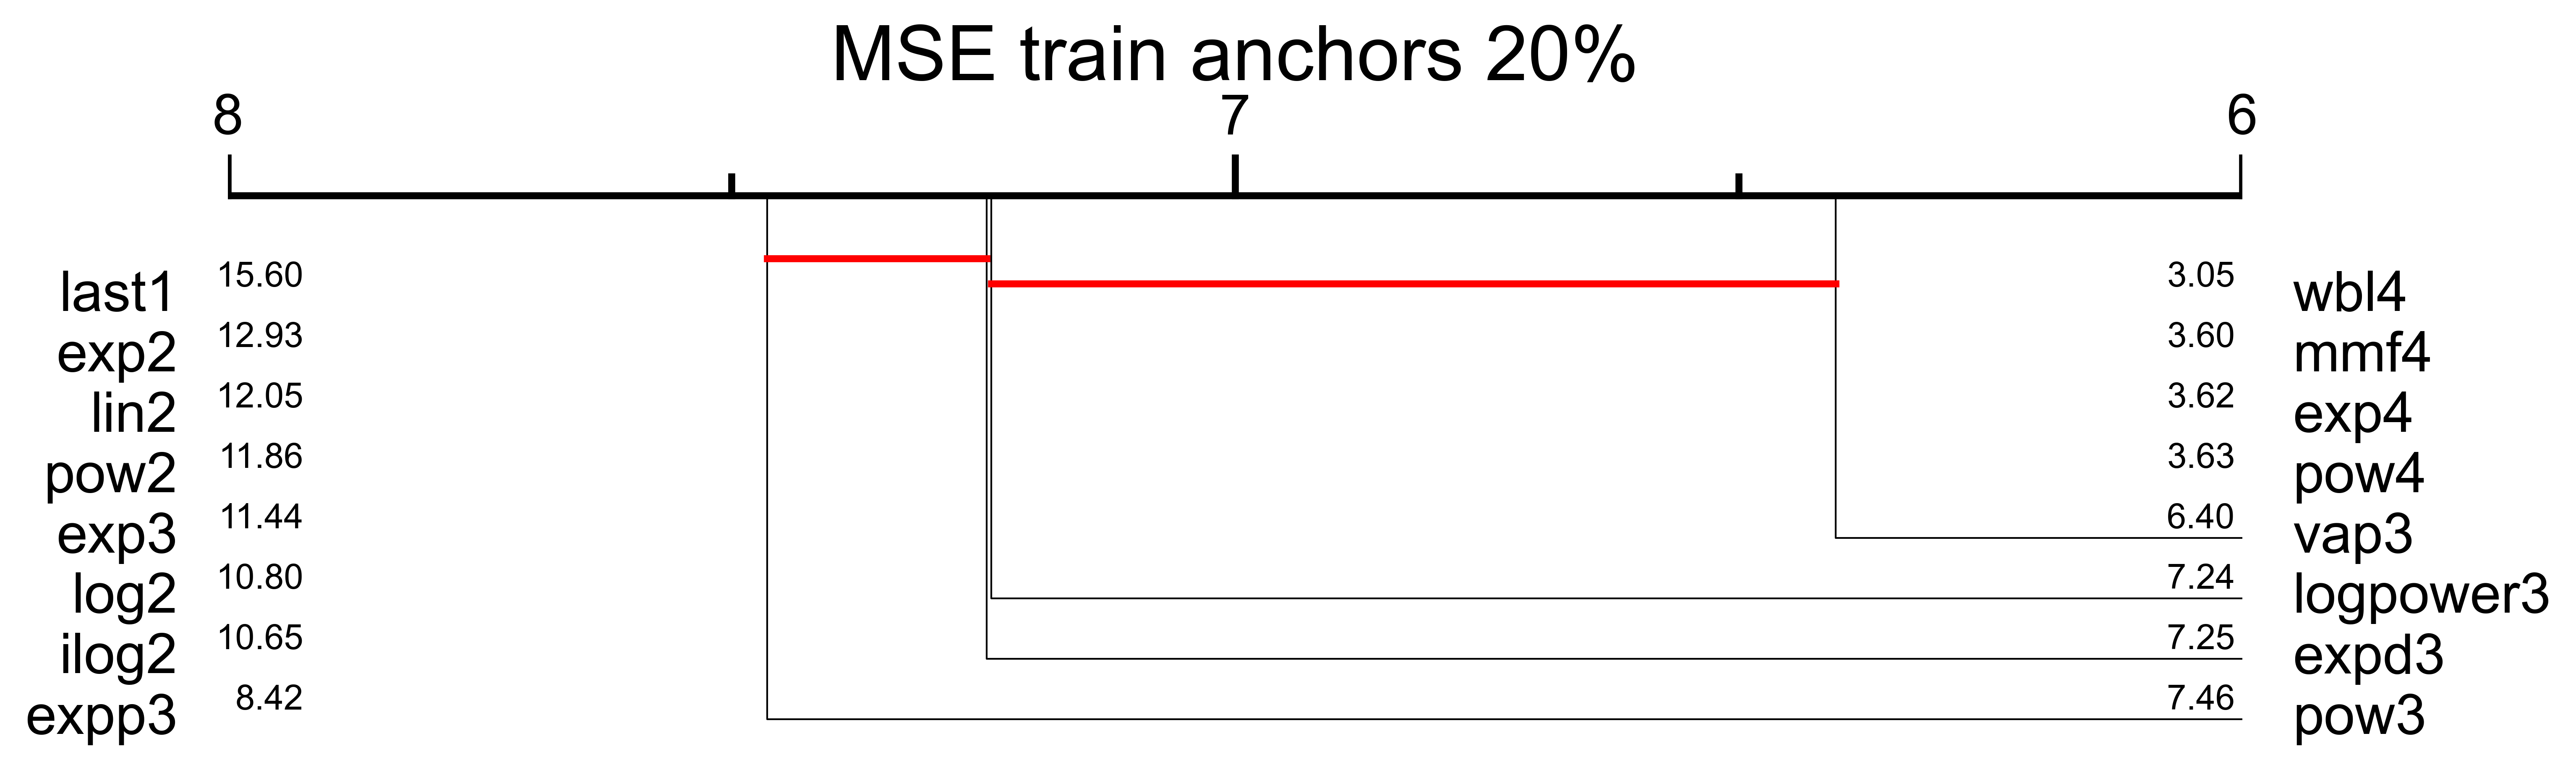

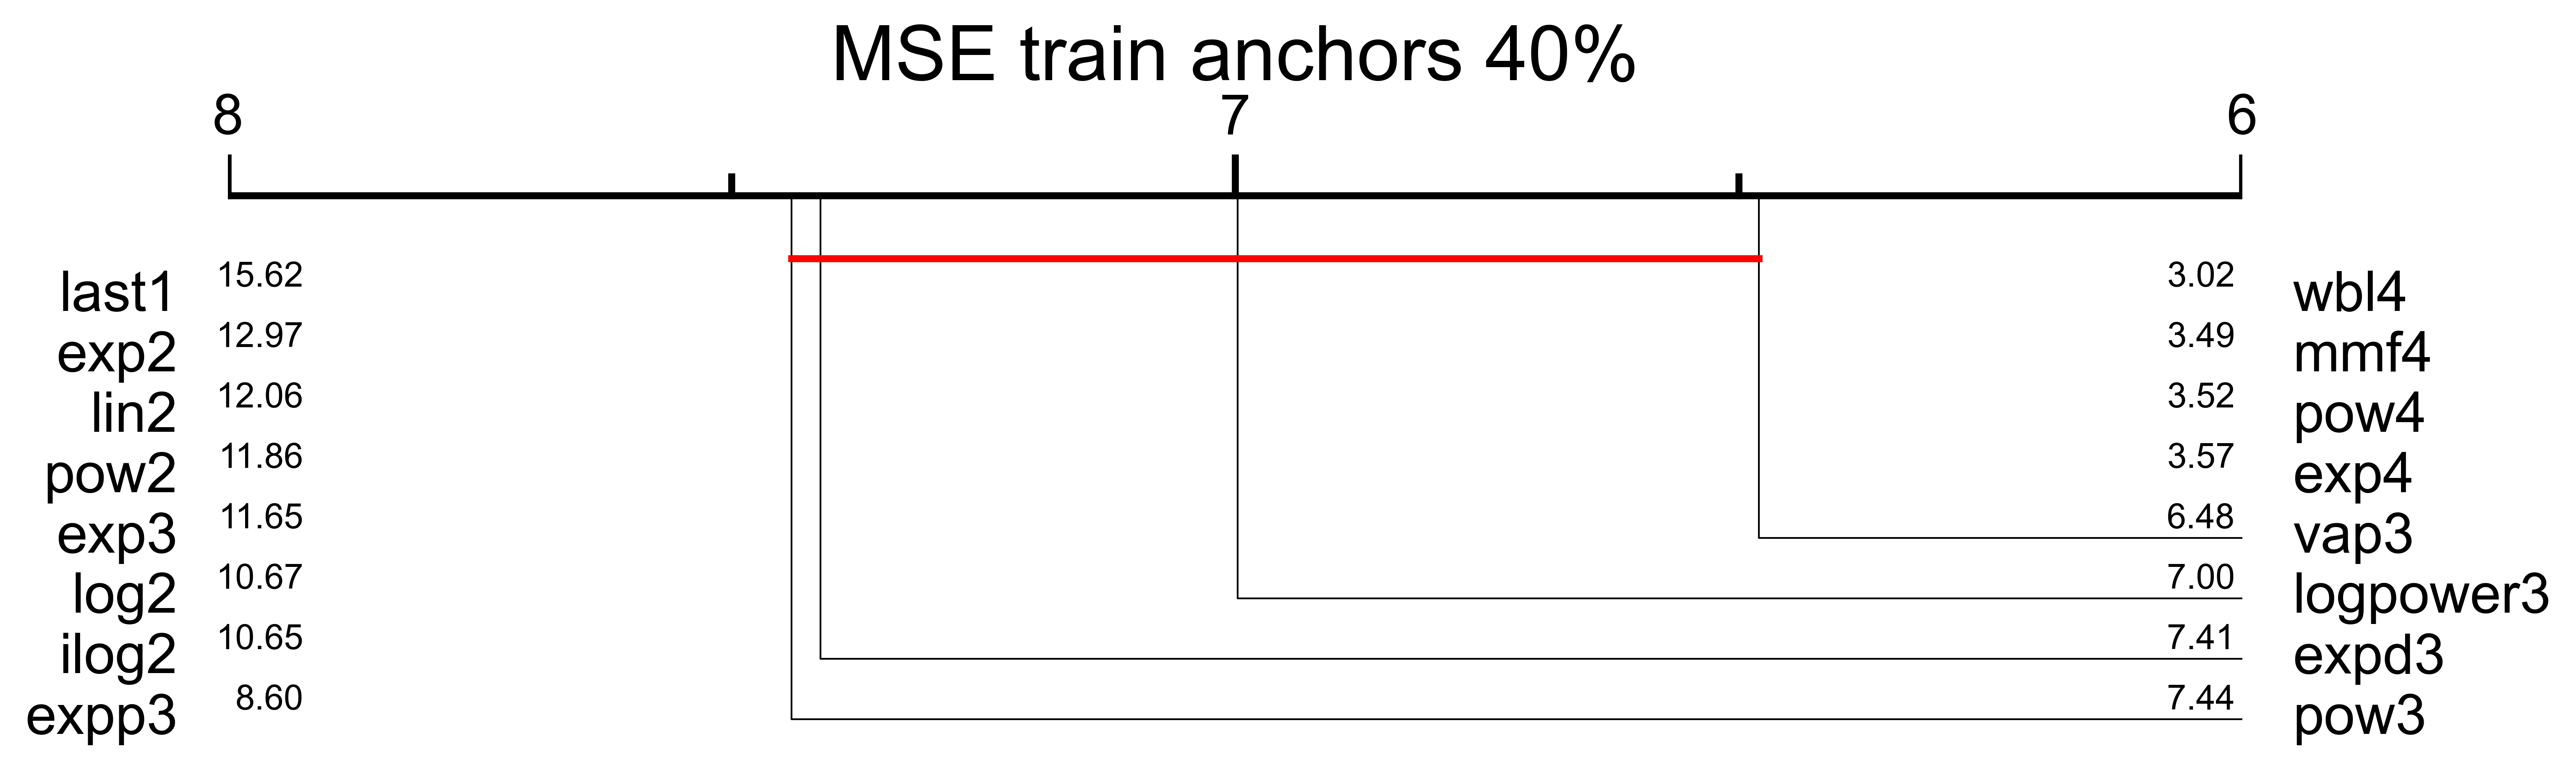

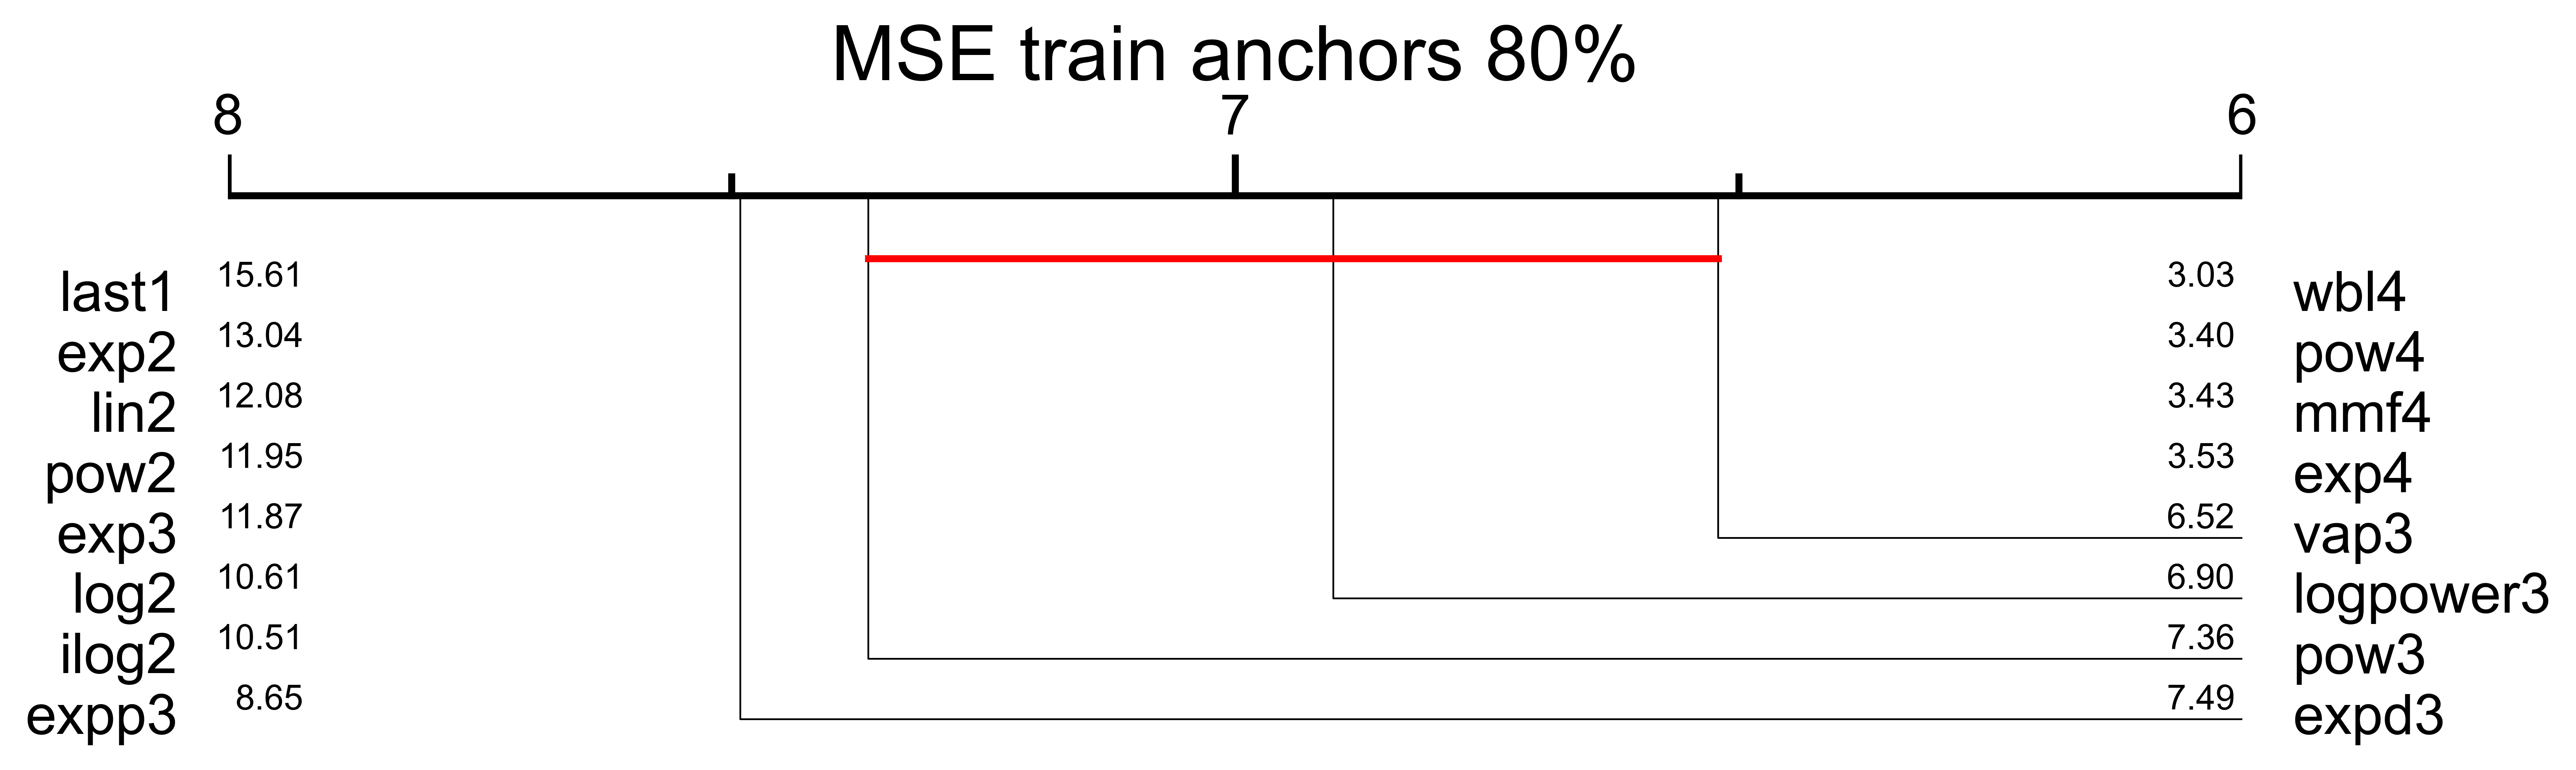

In [26]:
make_all_cd_plots(tables_MSE_trn,tables_MSE_trn_nan,'MSE train anchors','.eps')

# Visualize fit performances

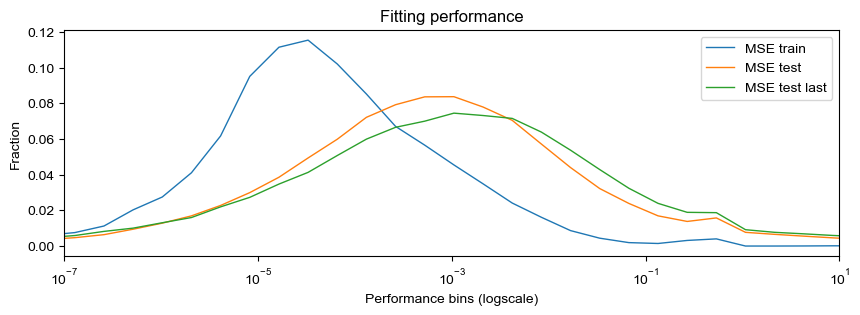

In [27]:

plt.figure(dpi=100,figsize=(10,3))

plot_metric(df_total['MSE_trn'],'MSE train')
plot_metric(df_total['MSE_tst'],'MSE test')
plot_metric(df_total['MSE_tst_last'],'MSE test last')

plt.xlabel('Performance bins (logscale)')
plt.ylabel('Fraction')
plt.legend()
plt.title('Fitting performance')
plt.xlim([1e-7,1e1])

plt.show()

Preprocess the data for the CDF plot

In [28]:
max_possible_anchors = {
    d: max(df_total[df_total["openmlid"] == d]["max_anchor_seen"]) for d in pd.unique(df_total["openmlid"])
}

df_for_cdf_plot = df_total.copy()
df_for_cdf_plot["relevant_max_anchor"] = [get_relevant_max_anchor(max_possible_anchors[openmlid]) for openmlid in df_total["openmlid"]]

df_for_cdf_plot_filtered = df_for_cdf_plot[df_for_cdf_plot["max_anchor_seen"] == df_for_cdf_plot["relevant_max_anchor"]]


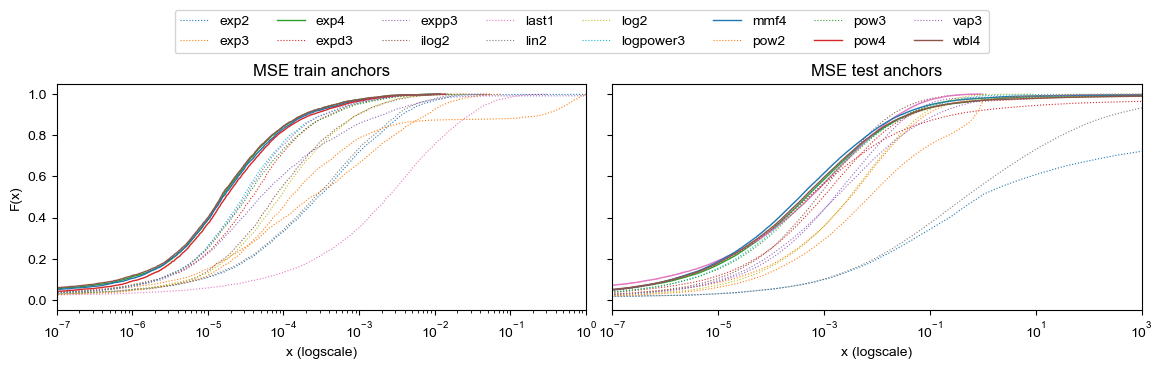

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, sharey=True, figsize=(14,3))

lw_default = 0.8
ls_default = ":"

i = 0

winners_fit = ["pow4", "mmf4", "exp4", "wbl4"]
winners_extrapolate = ["mmf4", "exp4", "wbl4", "last1"]

for [curve_model, df_curve_model] in df_for_cdf_plot_filtered.groupby('curve_model'):

    #plot_metric(df_curve_model['MSE_tst'],curve_model,ls=ls)

    lw = 1 if curve_model in winners_fit else lw_default
    ls = "-" if curve_model in winners_fit else ls_default

    empirical_cdf(ax1,df_curve_model['MSE_trn'],curve_model,ls=ls,label=curve_model, linewidth=lw)
    i += 1
    ax1.set_xlabel('x (logscale)')
    ax1.set_xscale('log')
    ax1.set_xlim([1e-7,1])
    ax1.set_ylabel('F(x)')
    ax1.set_title('MSE train anchors')


i = 0
for [curve_model, df_curve_model] in df_total.groupby('curve_model'):

    #if i > 5:
    #   break
    lw = 1 if curve_model in winners_extrapolate else lw_default
    ls = "-" if curve_model in winners_extrapolate else ls_default

    #plot_metric(df_curve_model['MSE_tst'],curve_model,ls=ls)
    empirical_cdf(ax2,df_curve_model['MSE_tst_last'],curve_model,ls=ls,label=curve_model, linewidth=lw)
    i += 1

    ax2.set_xlabel('x (logscale)')
    ax2.set_title('MSE test anchors')
    ax2.set_xscale('log')
    ax2.set_xlim([1e-7,1e3])


handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=8)

plt.subplots_adjust(wspace=0.05)

# Generate Latex

In [37]:
tables = [rank_table_tst_last,rank_table_tst,rank_table_trn]
for table in tables:
    print_pretty_rank_table_transpose(table)

\begin{table}[]
\ttfamily
\begin{tabular}{lllllllllllllllll}
curve&
       last1  &        pow2  &        log2  &        exp2  &        lin2  &       ilog2  &        pow3  &        exp3  &        vap3  &       expp3  &       expd3  &   logpower3  &        mmf4  &        wbl4  &        exp4  &        pow4  \\
all&
\cellcolor{r1}{6.12} &\cellcolor{r8}{10.72} &\cellcolor{r6}{9.37} &\cellcolor{r14}{14.78} &\cellcolor{r13}{13.99} &\cellcolor{r4}{7.70} &\cellcolor{r2}{6.56} &\cellcolor{r7}{9.94} &\cellcolor{r5}{8.42} &\cellcolor{r5}{8.49} &\cellcolor{r4}{7.99} &\cellcolor{r2}{6.71} &\cellcolor{r1}{5.82} &\cellcolor{r2}{6.31} &\cellcolor{r2}{6.54} &\cellcolor{r2}{6.53} \\
5\%&
\cellcolor{r3}{7.01} &\cellcolor{r6}{9.54} &\cellcolor{r5}{8.55} &\cellcolor{r14}{14.65} &\cellcolor{r13}{13.90} &\cellcolor{r2}{6.67} &\cellcolor{r2}{6.51} &\cellcolor{r6}{9.05} &\cellcolor{r6}{9.39} &\cellcolor{r4}{7.92} &\cellcolor{r4}{7.84} &\cellcolor{r3}{7.12} &\cellcolor{r2}{6.34} &\cellcolor{r3}{7.13} &\cellcolo